<a href="https://colab.research.google.com/github/BackBencher2424/BA820_Team_14_Project/blob/main/BA820_M3_Integrated_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BA820 — M3 Integrated Notebook (Best-of M2 EDA + Unified Preprocessing)

**Team 14 | Phase M3**

This notebook **reproduces the core concepts** from the four Phase M2 notebooks (Q1–Q4) while **combining the best EDA + preprocessing** into a single, consistent pipeline.  
You can directly compare M3 results with M2 results because the notebook preserves the **same kinds of visuals** (distributions, log-scale plots, UMAP/PCA, elbow/silhouette curves, quadrant “ghost” view, survival-category plots, and cluster profiles).

---

## What we combined (and how)

### Best EDA (combined from M2)
- **Column standardization + missingness table** (from **M2 Q2/Q3**)  
- **Top-missing bar chart** (from **M2 Q4**)  
- **Skew-aware log-scale distributions** for stars and Wikipedia views + key scatterplots (from **M2 Q2/Q3**)  
- **Duplicate check** using `pldb_id` (from **M2 Q3**)  
- **Timeline sanity check** on `appeared` (from **M2 Q3**)  

### Best Preprocessing (combined from M2)
- **Robust numeric casting** (`pd.to_numeric(..., errors="coerce")`) across key columns (from **M2 Q1/Q2/Q3**)  
- **Skew handling** using `log1p` / `log10(x+1)` for community metrics (from **M2 Q1/Q2/Q3**)  
- **Technical “extensions” parsing** and compact extension features (from **M2 Q1**)  
- **Longevity features**: `age`, `years_since_last_activity`, and `survival_category` (from **M2 Q4**)  
- **Ecosystem presence flags**: `has_domain`, `has_github`, `has_wikipedia` (from **M2 Q4**)  

### How integration is enforced
All analyses (Q1–Q4 reproduction + M3 integrated clustering) start from the **same** cleaned dataframe `df_clean`, and use analysis-specific “views”:
- `df_comm` for community / adoption signals  
- `df_tech` for technical/extension signals  
- `df_hype` for hype-vs-utility archetypes + ghost-language scoring  
- `df_long` for longevity / survival-based clustering  


In [ ]:
# =========================
# 0) Setup (Colab-friendly)
# =========================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# UMAP is not always installed by default on Colab
try:
    import umap.umap_ as umap
except Exception:
    !pip -q install umap-learn
    import umap.umap_ as umap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------- Consistent color scheme (use everywhere) ----------
# Discrete clusters: use the SAME palette across PCA/UMAP/scatter/cluster plots.
PALETTE = sns.color_palette("tab10", n_colors=10)          # stable, readable, consistent
HEATMAP_CMAP = "viridis"                                  # consistent heatmap palette
sns.set_theme(style="whitegrid")                          # clean grid style
sns.set_palette(PALETTE)

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

print("✅ Setup complete (consistent palette enabled).")


✅ Setup complete (consistent palette enabled).


In [ ]:
# =========================
# 1) Load data (NO fetch)
# =========================
DATA_PATH = "/content/languages.csv"   # You will upload this file into Colab runtime.

df_raw = pd.read_csv(DATA_PATH)

# Standardize column names (best practice used in M2 Q2/Q3)
df_raw.columns = [c.strip().lower() for c in df_raw.columns]

print("Loaded:", DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head()


Loaded: /content/languages.csv
Shape: (4303, 49)


,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,...,features_has_semantic_indentation,features_has_line_comments,line_comment_token,last_activity,number_of_users,number_of_jobs,origin_community,central_package_repository_count,file_type,is_open_source
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,...,False,True,//,2022,5550123,85206,Sun Microsystems,NaN,text,NaN
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,...,False,True,//,2022,5962666,63993,Netscape,NaN,text,NaN
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,...,False,True,//,2022,3793768,59919,Bell Labs,0.0,text,NaN
3,python,Python,NaN,pl,1991,Guido van Rossum,https://www.python.org/,python.org,1995.0,https://www.programiz.com/python-programming/k...,...,True,True,#,2022,2818037,46976,Centrum Wiskunde & Informatica,NaN,text,NaN
4,sql,SQL,NaN,queryLanguage,1974,Donald D. Chamberlin and Raymond F. Boyce,NaN,NaN,NaN,NaN,...,False,True,--,2022,7179119,219617,IBM,0.0,text,NaN


## 2) Best-of M2 EDA (Unified)

This section **replaces repeated EDA** across M2 notebooks.  
It keeps the *most grading-relevant* EDA visuals used in M2 so you can compare results consistently.


In [ ]:
# 2.1 Basic schema + dtype overview
display(df_raw.dtypes.value_counts().to_frame("count"))
display(df_raw.head(3))


,count
object,25
float64,18
int64,6


,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,...,features_has_semantic_indentation,features_has_line_comments,line_comment_token,last_activity,number_of_users,number_of_jobs,origin_community,central_package_repository_count,file_type,is_open_source
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,...,False,True,//,2022,5550123,85206,Sun Microsystems,NaN,text,NaN
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,...,False,True,//,2022,5962666,63993,Netscape,NaN,text,NaN
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,...,False,True,//,2022,3793768,59919,Bell Labs,0.0,text,NaN


,missing_count,missing_pct
github_language_ace_mode,3838,89.19
github_language_tm_scope,3837,89.17
github_language_type,3837,89.17
github_language_file_extensions,3833,89.08
github_language_repos,3833,89.08
line_comment_token,3831,89.03
github_language,3829,88.98
domain_name_registered,3801,88.33
is_open_source,3792,88.12
features_has_line_comments,3765,87.50


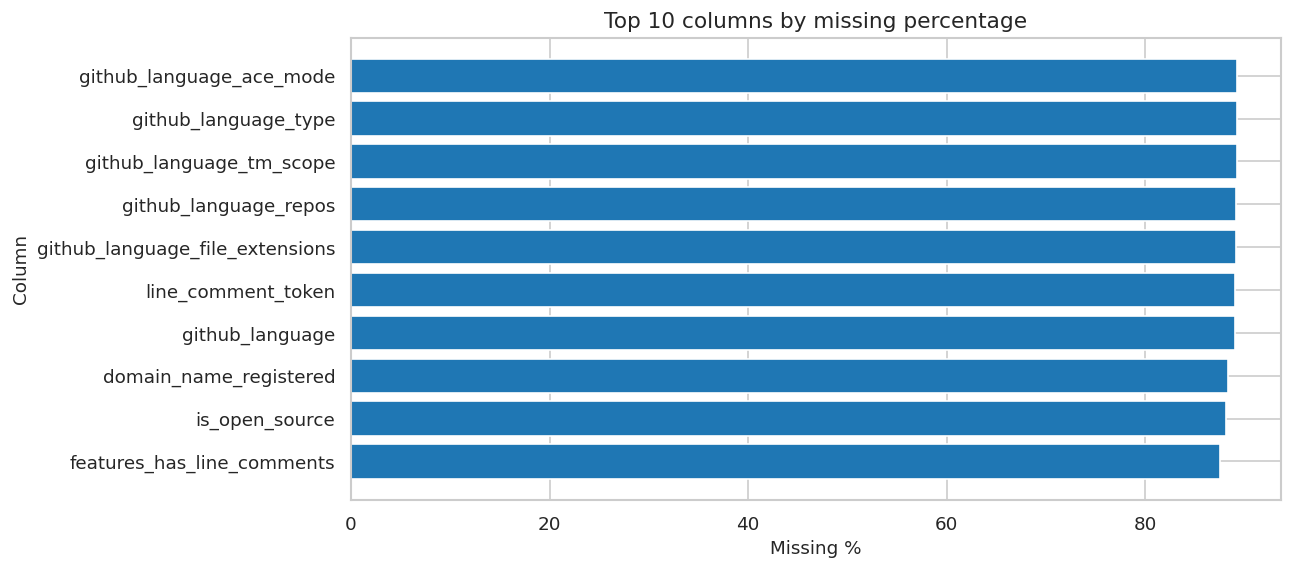

In [ ]:
# 2.2 Missingness summary (M2 Q2/Q3 style)
missing = (df_raw.isna().sum()
           .to_frame("missing_count")
           .assign(missing_pct=lambda x: (x["missing_count"] / len(df_raw) * 100).round(2))
           .sort_values("missing_pct", ascending=False))
display(missing.head(25))

# Top-missing bar chart (M2 Q4 style)
top10 = missing[missing["missing_count"] > 0].head(10).sort_values("missing_pct", ascending=True)
plt.figure(figsize=(10,5))
plt.barh(top10.index.astype(str), top10["missing_pct"].values)
plt.title("Top 10 columns by missing percentage")
plt.xlabel("Missing %")
plt.ylabel("Column")
plt.show()


In [ ]:
# 2.3 Duplicate check (M2 Q3 idea)
if "pldb_id" in df_raw.columns:
    dup_count = df_raw["pldb_id"].duplicated().sum()
    print("Duplicate pldb_id rows:", dup_count)
else:
    print("pldb_id column not found — skipping duplicate-id check.")


Duplicate pldb_id rows: 0


Core numeric columns found: ['github_repo_stars', 'wikipedia_daily_page_views', 'number_of_users', 'number_of_jobs', 'github_repo_forks', 'github_repo_subscribers', 'github_repo_issues', 'github_language_repos', 'wikipedia_backlinks_count', 'wikipedia_revision_count', 'book_count', 'central_package_repository_count']


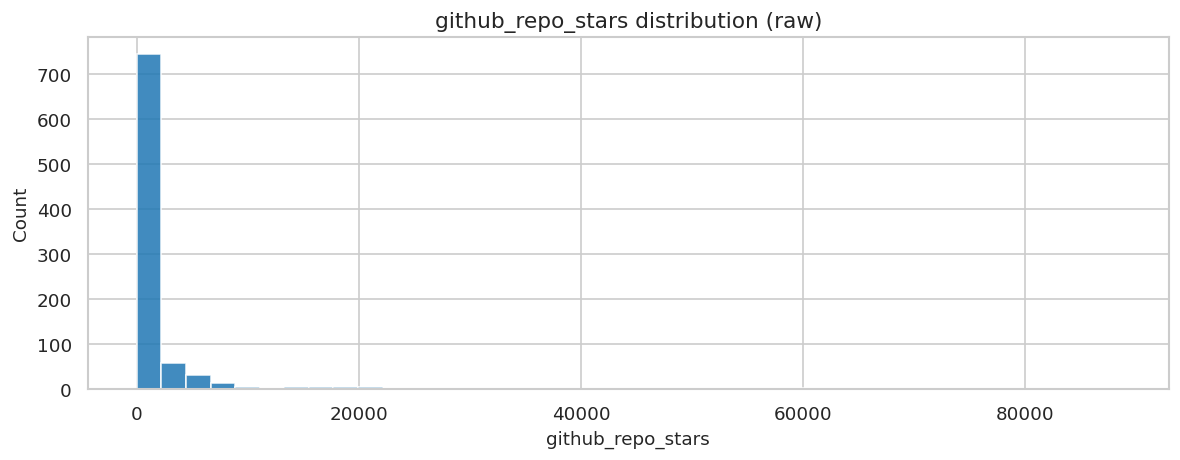

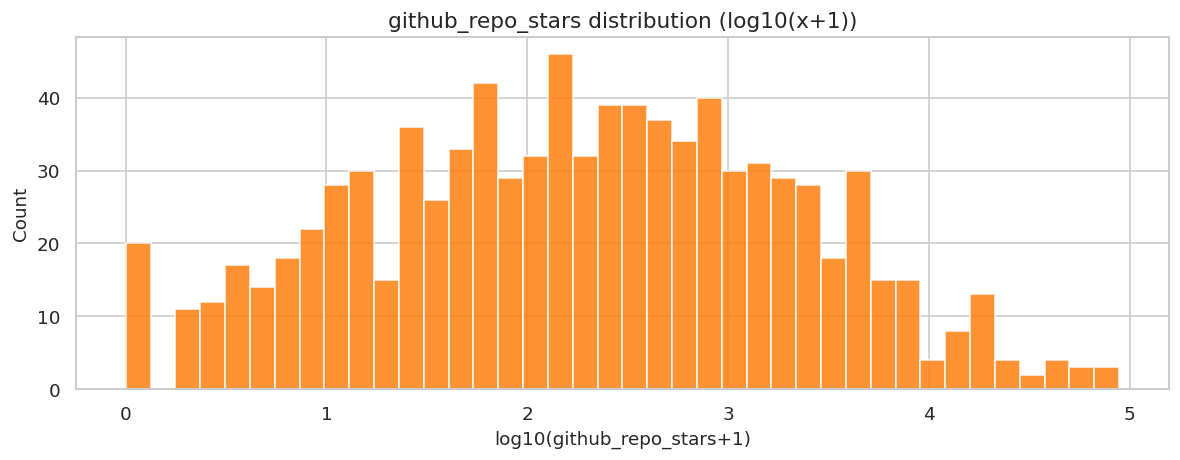

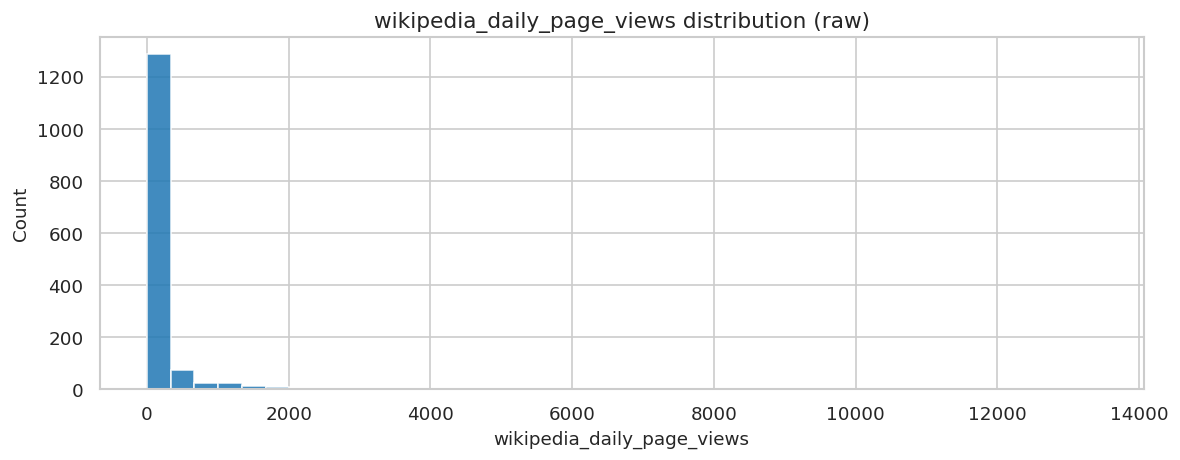

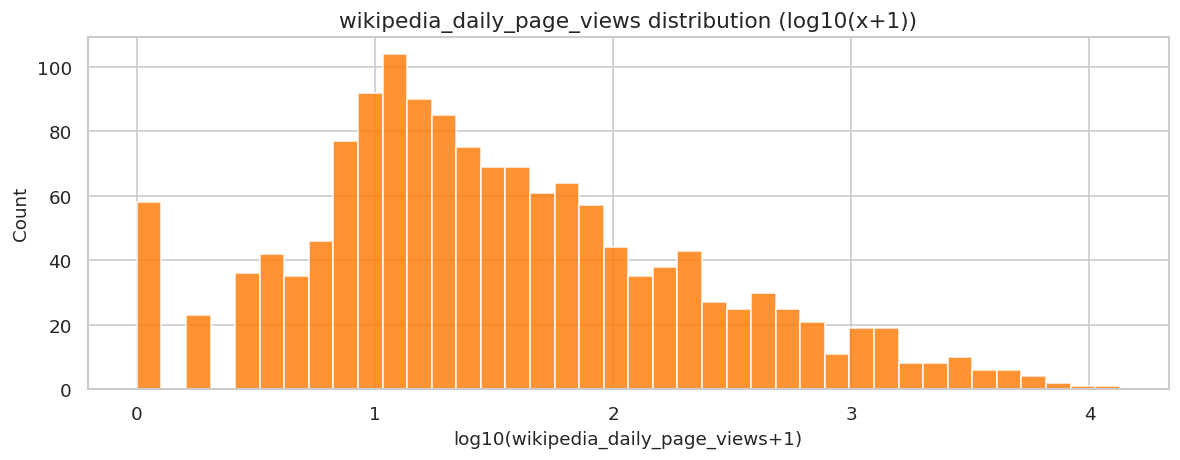

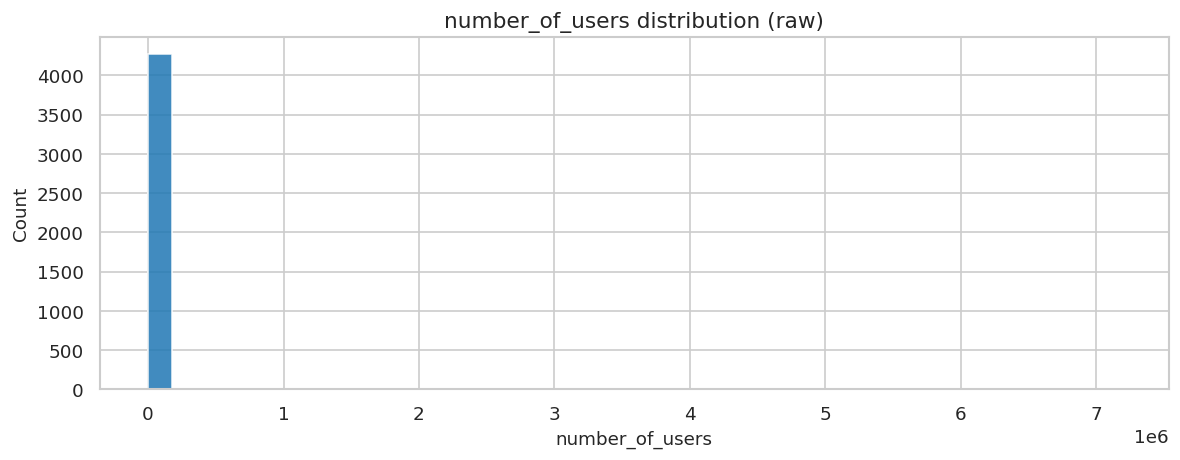

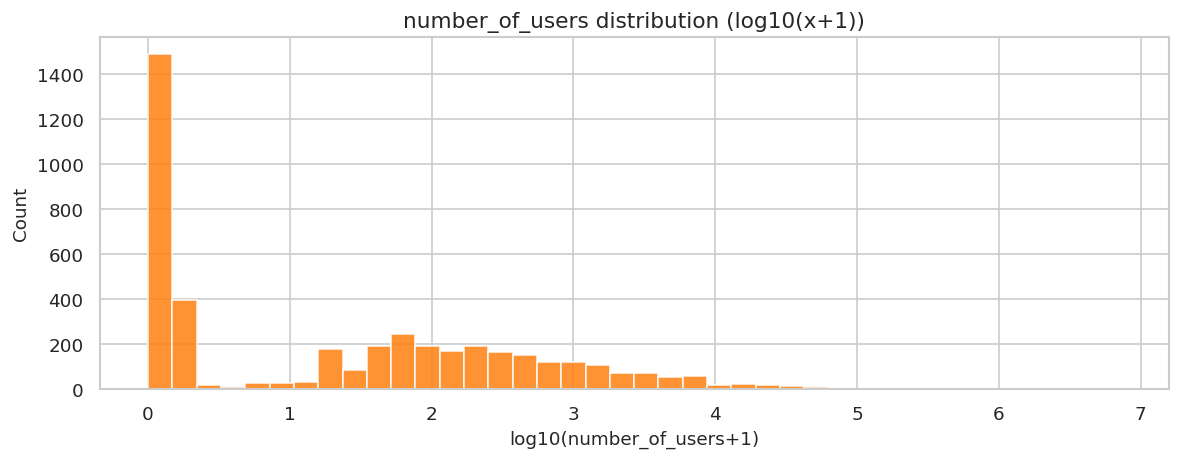

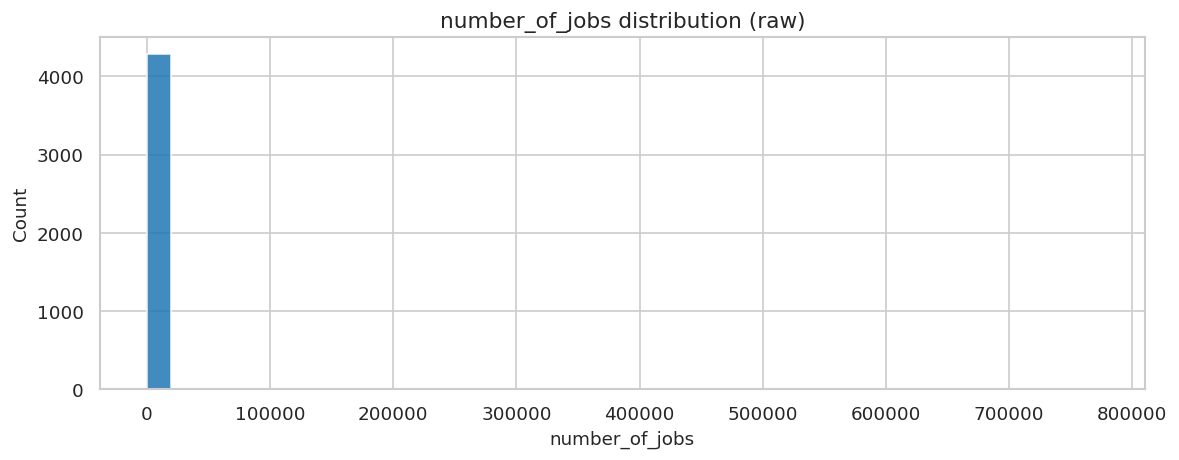

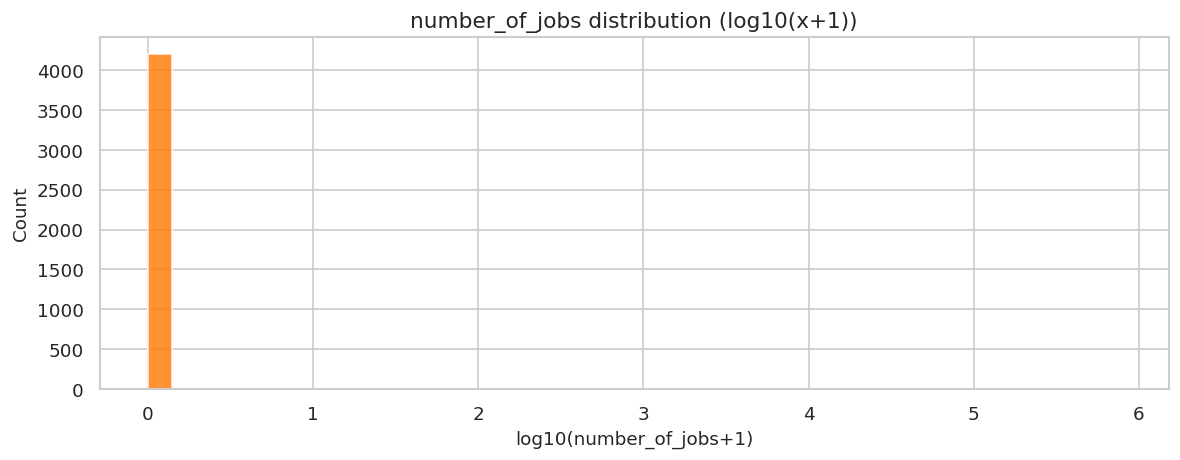

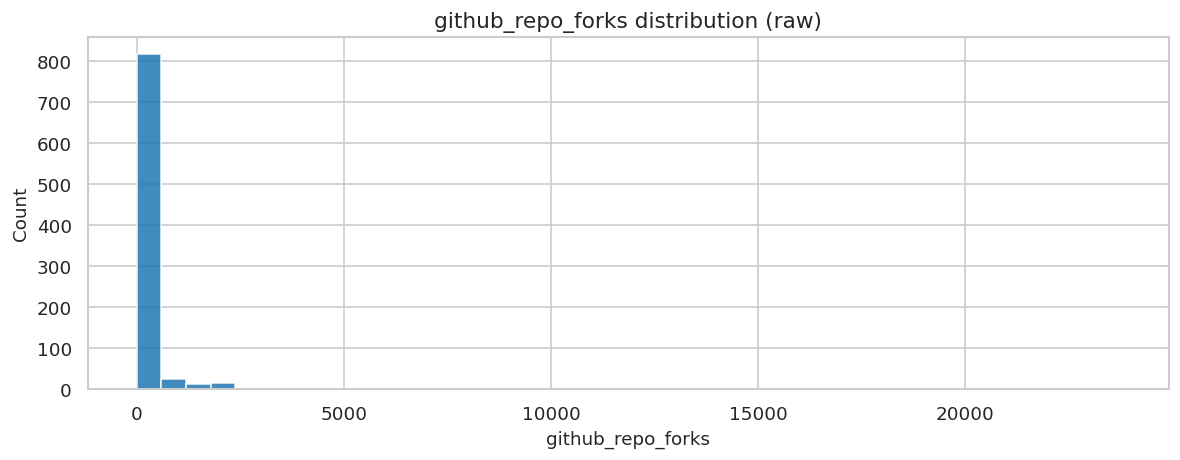

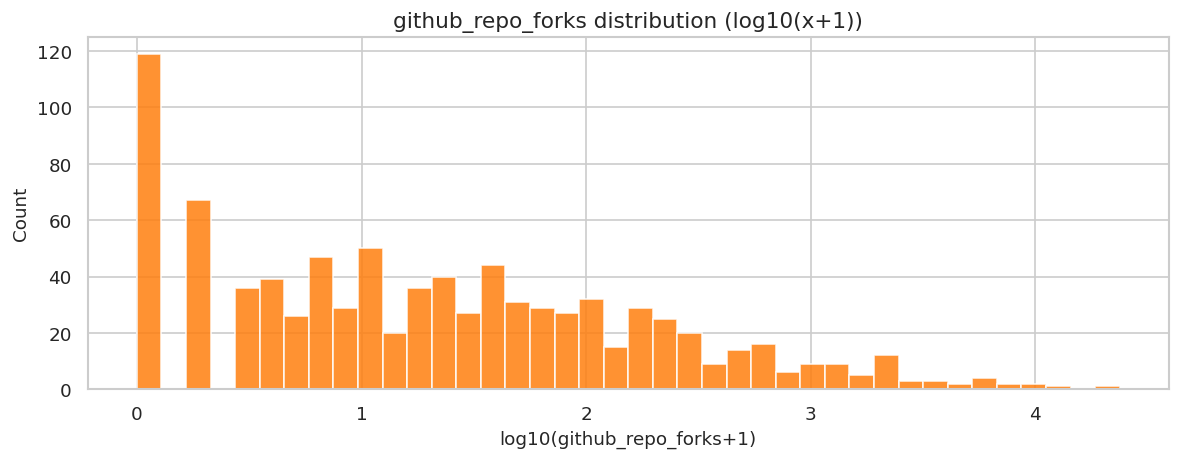

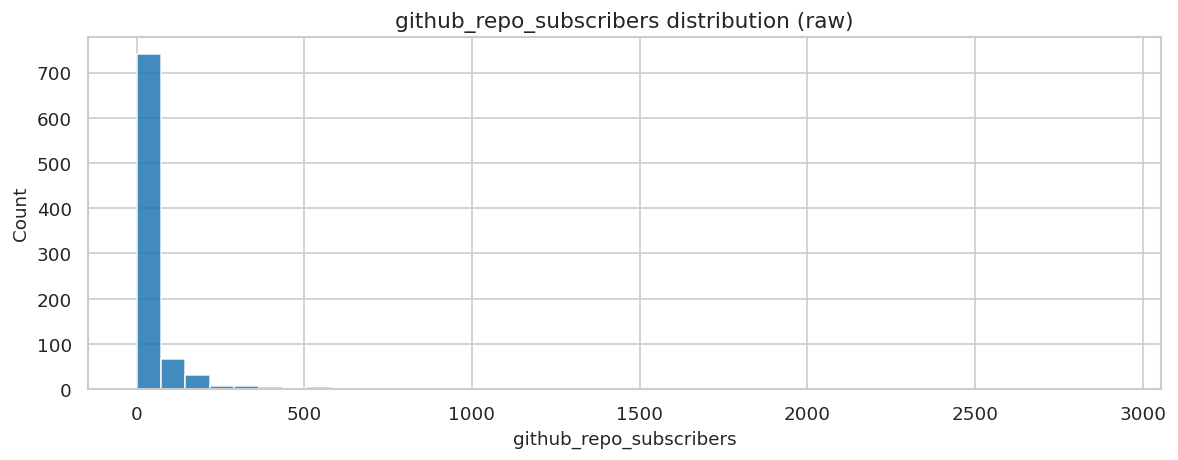

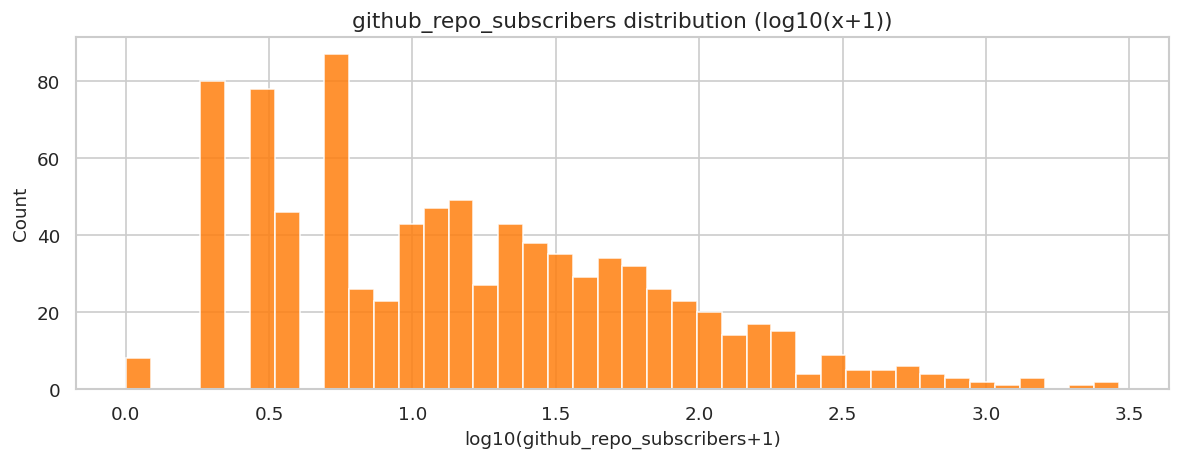

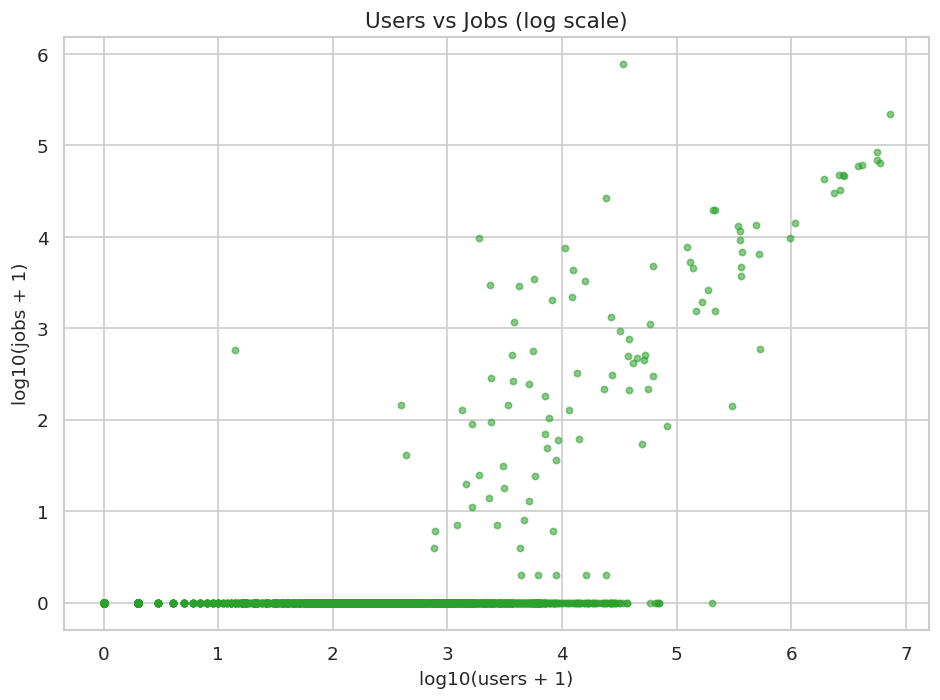

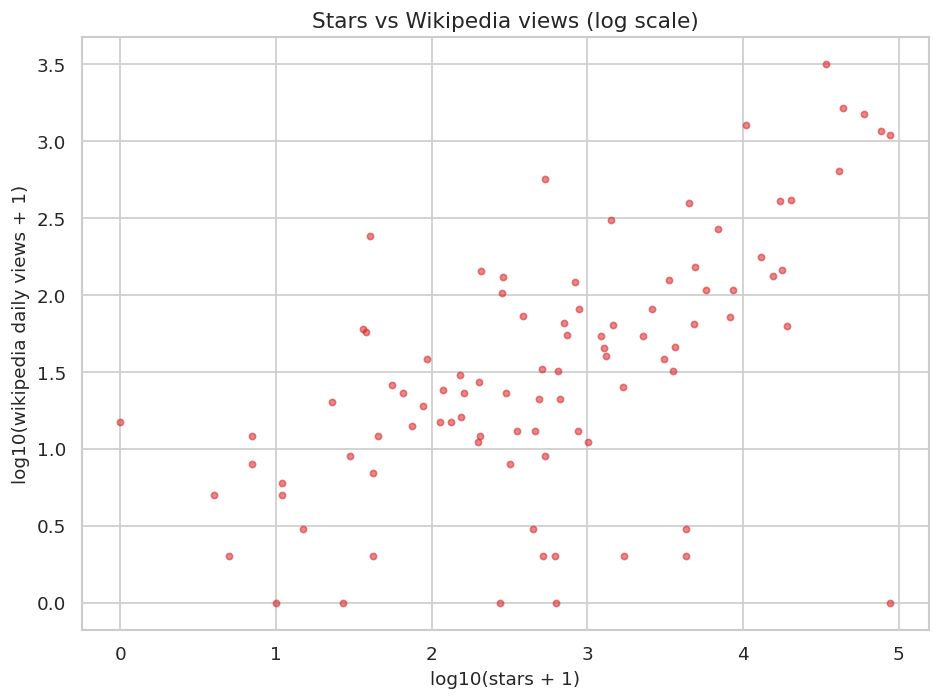

In [ ]:
# 2.4 Key distributions + log-scale views (M2 Q2/Q3)
def safe_numeric(s):
    return pd.to_numeric(s, errors="coerce")

core_cols = [
    "github_repo_stars","wikipedia_daily_page_views",
    "number_of_users","number_of_jobs",
    "github_repo_forks","github_repo_subscribers","github_repo_issues",
    "github_language_repos","wikipedia_backlinks_count","wikipedia_revision_count",
    "book_count","central_package_repository_count"
]
available_core = [c for c in core_cols if c in df_raw.columns]
print("Core numeric columns found:", available_core)

# Distributions (raw + log10(x+1)) — consistent labeling
for c in available_core[:6]:
    x = safe_numeric(df_raw[c]).dropna()
    if len(x) == 0:
        continue

    plt.figure(figsize=(10,4))
    plt.hist(x, bins=40, color=PALETTE[0], alpha=0.85)
    plt.title(f"{c} distribution (raw)")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.hist(np.log10(x.clip(lower=0) + 1), bins=40, color=PALETTE[1], alpha=0.85)
    plt.title(f"{c} distribution (log10(x+1))")
    plt.xlabel(f"log10({c}+1)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def log10p1(s):
    return np.log10(s.clip(lower=0) + 1)

# Key M2-style scatterplots (log scale) with labels + legend
if {"number_of_users","number_of_jobs"}.issubset(df_raw.columns):
    tmp = df_raw[["number_of_users","number_of_jobs"]].apply(safe_numeric).dropna()
    plt.figure(figsize=(8,6))
    plt.scatter(log10p1(tmp["number_of_users"]), log10p1(tmp["number_of_jobs"]), s=14, alpha=0.55, color=PALETTE[2])
    plt.xlabel("log10(users + 1)")
    plt.ylabel("log10(jobs + 1)")
    plt.title("Users vs Jobs (log scale)")
    plt.tight_layout()
    plt.show()

if {"github_repo_stars","wikipedia_daily_page_views"}.issubset(df_raw.columns):
    tmp = df_raw[["github_repo_stars","wikipedia_daily_page_views"]].apply(safe_numeric).dropna()
    plt.figure(figsize=(8,6))
    plt.scatter(log10p1(tmp["github_repo_stars"]), log10p1(tmp["wikipedia_daily_page_views"]), s=14, alpha=0.55, color=PALETTE[3])
    plt.xlabel("log10(stars + 1)")
    plt.ylabel("log10(wikipedia daily views + 1)")
    plt.title("Stars vs Wikipedia views (log scale)")
    plt.tight_layout()
    plt.show()


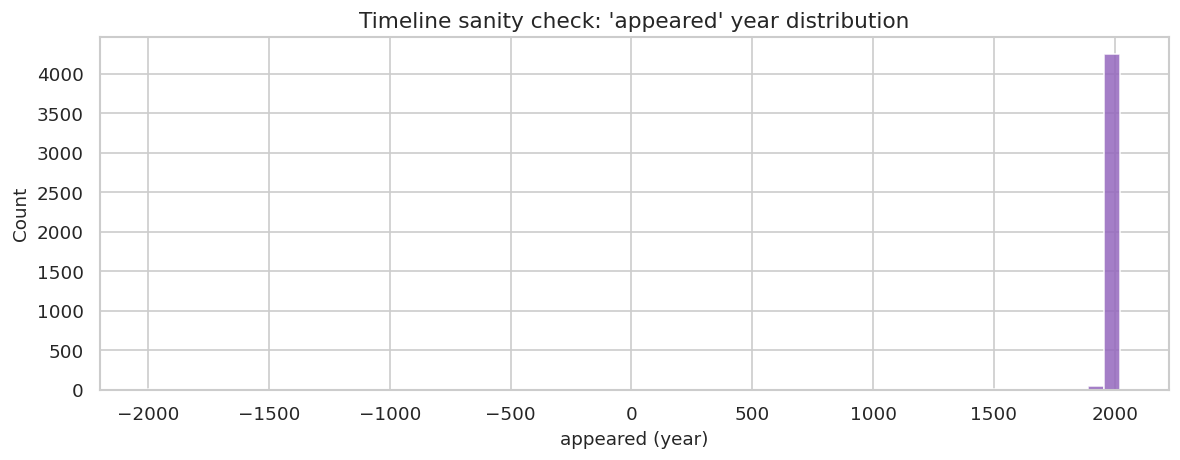

In [ ]:
# 2.5 Timeline sanity check (M2 Q3)
if "appeared" in df_raw.columns:
    appeared = pd.to_numeric(df_raw["appeared"], errors="coerce")
    plt.figure(figsize=(10,4))
    plt.hist(appeared.dropna(), bins=60, color=PALETTE[4], alpha=0.85)
    plt.title("Timeline sanity check: 'appeared' year distribution")
    plt.xlabel("appeared (year)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No 'appeared' column found.")


## 3) Unified Preprocessing (Best-of M2)

Goal: create `df_clean` + analysis-ready views while keeping M2 concepts intact:
- consistent numeric casting  
- consistent log transforms for skewed metrics  
- extension parsing (technical signals)  
- longevity / survival features  


In [ ]:
# 3.1 Start with a clean working copy
df_clean = df_raw.copy()

# 3.2 Numeric casting (common across M2 Q1/Q2/Q3/Q4)
numeric_cols = [
    "appeared","last_activity","language_rank",
    "github_repo_stars","github_repo_forks","github_repo_subscribers","github_repo_issues",
    "github_language_repos",
    "wikipedia_daily_page_views","wikipedia_backlinks_count","wikipedia_revision_count",
    "book_count","central_package_repository_count",
    "number_of_users","number_of_jobs",
    "ecosystem_score"
]
for c in numeric_cols:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

# 3.3 Date casting (Q2/Q3)
date_cols = ["github_repo_updated","github_repo_created","github_repo_first_commit","wikipedia_created"]
for c in date_cols:
    if c in df_clean.columns:
        df_clean[c] = pd.to_datetime(df_clean[c], errors="coerce")

# 3.4 Boolean casting for language feature flags (Q4)
bool_cols = ["features_has_comments","features_has_semantic_indentation","features_has_line_comments"]
for c in bool_cols:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].astype("boolean")

# 3.5 Treat negative placeholders as missing, then clip counts at 0
if "wikipedia_daily_page_views" in df_clean.columns:
    df_clean.loc[df_clean["wikipedia_daily_page_views"] < 0, "wikipedia_daily_page_views"] = np.nan

count_like = [
    "github_repo_stars","github_repo_forks","github_repo_subscribers","github_repo_issues",
    "github_language_repos",
    "wikipedia_daily_page_views","wikipedia_backlinks_count","wikipedia_revision_count",
    "book_count","central_package_repository_count",
    "number_of_users","number_of_jobs",
]
for c in count_like:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].clip(lower=0)

# 3.6 Timeline filter (M2 Q3): remove very early "appeared" years for comparability
if "appeared" in df_clean.columns:
    df_clean = df_clean[(df_clean["appeared"].isna()) | (df_clean["appeared"] > 1544)].copy()

# 3.7 Longevity features (M2 Q4)
REF_YEAR = 2023
if "appeared" in df_clean.columns:
    df_clean["age"] = REF_YEAR - df_clean["appeared"]
if "last_activity" in df_clean.columns:
    df_clean["years_since_last_activity"] = REF_YEAR - df_clean["last_activity"]

if "years_since_last_activity" in df_clean.columns:
    bins = [-np.inf, 5, 15, np.inf]
    labels = ["Active", "Maintained", "Dormant"]
    df_clean["survival_category"] = pd.cut(
        df_clean["years_since_last_activity"], bins=bins, labels=labels, right=False
    )

# 3.8 Ecosystem presence flags (M2 Q4)
for col, newcol in [("domain_name","has_domain"), ("github_repo","has_github"), ("wikipedia","has_wikipedia")]:
    if col in df_clean.columns:
        df_clean[newcol] = df_clean[col].notna().astype(int)

# 3.9 Log features (Q1/Q2/Q3/Q4)
def add_log_features(df_in, col, kind="log1p"):
    if col not in df_in.columns:
        return
    x = pd.to_numeric(df_in[col], errors="coerce").fillna(0).clip(lower=0)
    if kind == "log1p":
        df_in[f"log1p_{col}"] = np.log1p(x)
    elif kind == "log10":
        df_in[f"log10_{col}"] = np.log10(x + 1)

for c in ["number_of_users","number_of_jobs","wikipedia_daily_page_views","github_repo_stars",
          "github_repo_forks","github_repo_subscribers","wikipedia_backlinks_count","wikipedia_revision_count",
          "book_count","central_package_repository_count"]:
    add_log_features(df_clean, c, "log1p")
    add_log_features(df_clean, c, "log10")

print("✅ df_clean ready | shape:", df_clean.shape)
df_clean.head(3)


✅ df_clean ready | shape: (4293, 75)


,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,...,log1p_github_repo_subscribers,log10_github_repo_subscribers,log1p_wikipedia_backlinks_count,log10_wikipedia_backlinks_count,log1p_wikipedia_revision_count,log10_wikipedia_revision_count,log1p_book_count,log10_book_count,log1p_central_package_repository_count,log10_central_package_repository_count
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,...,0.0,0.0,9.353921,4.062356,8.964312,3.893151,5.996452,2.604226,0.0,0.0
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,...,0.0,0.0,9.103089,3.953421,8.721276,3.787602,5.863631,2.546543,0.0,0.0
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,...,0.0,0.0,9.267288,4.024732,8.897956,3.864333,4.369448,1.897627,0.0,0.0


### 3.10 Technical signal preprocessing: parse GitHub language extensions (M2 Q1)

Creates:
- `num_extensions_listed`
- top-K extension one-hot columns


In [ ]:
import re

def parse_extensions(ext_str):
    # Parse space-separated extensions into cleaned tokens.
    if pd.isna(ext_str) or not isinstance(ext_str, str):
        return []
    tokens = ext_str.strip().lower().split()
    cleaned=[]
    for t in tokens:
        t=t.strip()
        if not t:
            continue
        t = re.sub(r"[^a-z0-9\.\_\-]+","",t)
        if t:
            cleaned.append(t)
    return cleaned

def sanitize_token(token):
    return "ext_" + re.sub(r"[^a-z0-9]+", "_", token.lower()).strip("_")

if "github_language_file_extensions" in df_clean.columns:
    ext_tokens = df_clean["github_language_file_extensions"].apply(parse_extensions)
    df_clean["num_extensions_listed"] = ext_tokens.apply(lambda x: len(set(x)))

    K = 30
    all_ext = ext_tokens.explode()
    top_ext = all_ext.value_counts().head(K).index.tolist()
    for e in top_ext:
        df_clean[sanitize_token(e)] = ext_tokens.apply(lambda xs: int(e in set(xs)))

    print(f"✅ Extension features added: num_extensions_listed + {len(top_ext)} dummies")
else:
    print("github_language_file_extensions not found — skipping extension feature engineering.")


✅ Extension features added: num_extensions_listed + 30 dummies


## 4) Analysis-ready views (shared inputs for Q1–Q4 + M3)

In [ ]:
# Community / adoption view (Q1 community + integrated M3)
comm_cols = [
    "appeared","last_activity",
    "log1p_number_of_users","log1p_number_of_jobs",
    "log1p_wikipedia_daily_page_views","log1p_github_repo_stars",
    "log1p_github_repo_forks","log1p_github_repo_subscribers",
    "log1p_wikipedia_backlinks_count","log1p_wikipedia_revision_count",
    "log1p_book_count","log1p_central_package_repository_count",
]
df_comm = df_clean[[c for c in comm_cols if c in df_clean.columns]].copy()

# Technical view (Q1 technical)
tech_cols = ["appeared","last_activity","num_extensions_listed"]
tech_cols += [c for c in df_clean.columns if c.startswith("ext_")]
df_tech = df_clean[[c for c in tech_cols if c in df_clean.columns]].copy()

# Hype vs utility view (Q2 archetypes + Q3 ghost)
hype_cols = [
    "title","appeared","last_activity",
    "log10_github_repo_stars","log10_wikipedia_daily_page_views",
    "log10_number_of_users","log10_number_of_jobs",
    "log10_github_repo_subscribers","log10_github_repo_forks",
]
df_hype = df_clean[[c for c in hype_cols if c in df_clean.columns]].copy()

# Longevity view (Q4)
long_cols = [
    "type","file_type","features_has_comments","features_has_semantic_indentation","features_has_line_comments",
    "has_domain","has_github","has_wikipedia",
    "ecosystem_score","age","years_since_last_activity","survival_category",
    "log1p_number_of_users","log1p_number_of_jobs","log1p_book_count","log1p_central_package_repository_count",
]
df_long = df_clean[[c for c in long_cols if c in df_clean.columns]].copy()

print("df_comm:", df_comm.shape)
print("df_tech:", df_tech.shape)
print("df_hype:", df_hype.shape)
print("df_long:", df_long.shape)


df_comm: (4293, 12)
df_tech: (4293, 33)
df_hype: (4293, 9)
df_long: (4293, 15)


## 5) Shared utilities (silhouette sweep, PCA/UMAP plots)

In [ ]:
def build_numeric_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

pipe = build_numeric_pipeline()

def silhouette_sweep_kmeans(X, k_list):
    rows=[]
    for k in k_list:
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        labels = model.fit_predict(X)
        s = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
        rows.append({"k":k, "silhouette":s, "inertia":model.inertia_})
    return pd.DataFrame(rows)

def plot_elbow_sil(df_scores, title_prefix=""):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    ax[0].plot(df_scores["k"], df_scores["inertia"], marker="o")
    ax[0].set_title(f"{title_prefix} Elbow (Inertia)")
    ax[0].set_xlabel("Number of clusters (k)")
    ax[0].set_ylabel("Inertia (within-cluster SSE)")

    ax[1].plot(df_scores["k"], df_scores["silhouette"], marker="o")
    ax[1].set_title(f"{title_prefix} Silhouette vs k")
    ax[1].set_xlabel("Number of clusters (k)")
    ax[1].set_ylabel("Silhouette score")
    plt.tight_layout()
    plt.show()

def _cluster_color_map(labels):
    uniq = sorted(pd.unique(pd.Series(labels).dropna()))
    color_map = {u: PALETTE[i % len(PALETTE)] for i, u in enumerate(uniq)}
    return uniq, color_map

def scatter_clusters(Z, labels, title, xlabel, ylabel, legend_title="Cluster"):
    labels = np.asarray(labels)
    uniq, cmap = _cluster_color_map(labels)

    plt.figure(figsize=(8,6))
    for u in uniq:
        m = labels == u
        plt.scatter(Z[m,0], Z[m,1], s=14, alpha=0.65, color=cmap[u], label=str(u))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=legend_title, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def pca_scatter(X, labels, title="PCA scatter"):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X)
    scatter_clusters(Z, labels, title=title, xlabel="PC1", ylabel="PC2", legend_title="Cluster")
    return pca, Z

def umap_scatter(X, labels, title="UMAP scatter", n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=RANDOM_STATE)
    Z = reducer.fit_transform(X)
    scatter_clusters(Z, labels, title=title, xlabel="UMAP-1", ylabel="UMAP-2", legend_title="Cluster")
    return reducer, Z

k_list = list(range(2, 11))


## 6) Reproduce M2 Q1 (Vishesh): Technical vs Community clustering

,k,silhouette,inertia
0,2,0.963053,128367.683256
1,3,0.964505,120821.306758
2,4,0.965073,116247.297440
3,5,0.965362,112588.883780
4,6,0.966300,108292.169104
5,7,0.967107,102017.617220
6,8,0.961753,97780.939393
7,9,0.963348,87411.499407
8,10,0.964841,82836.409696


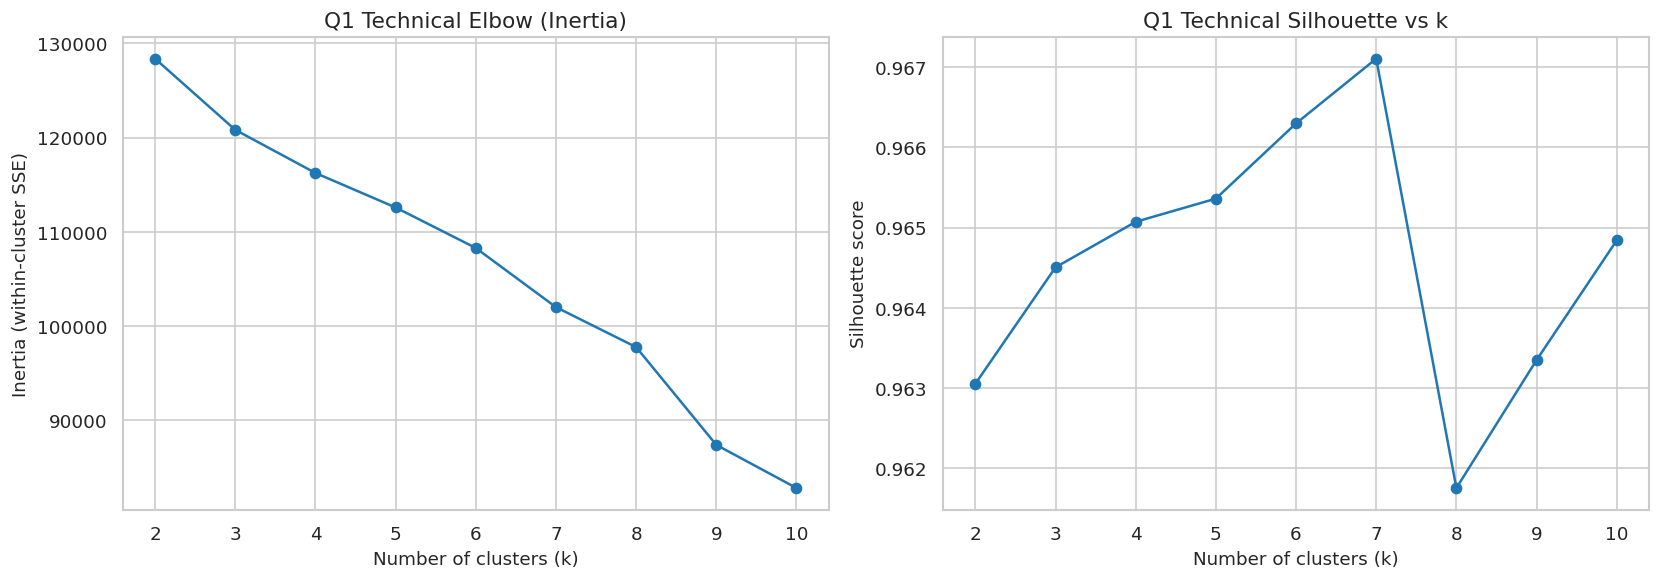

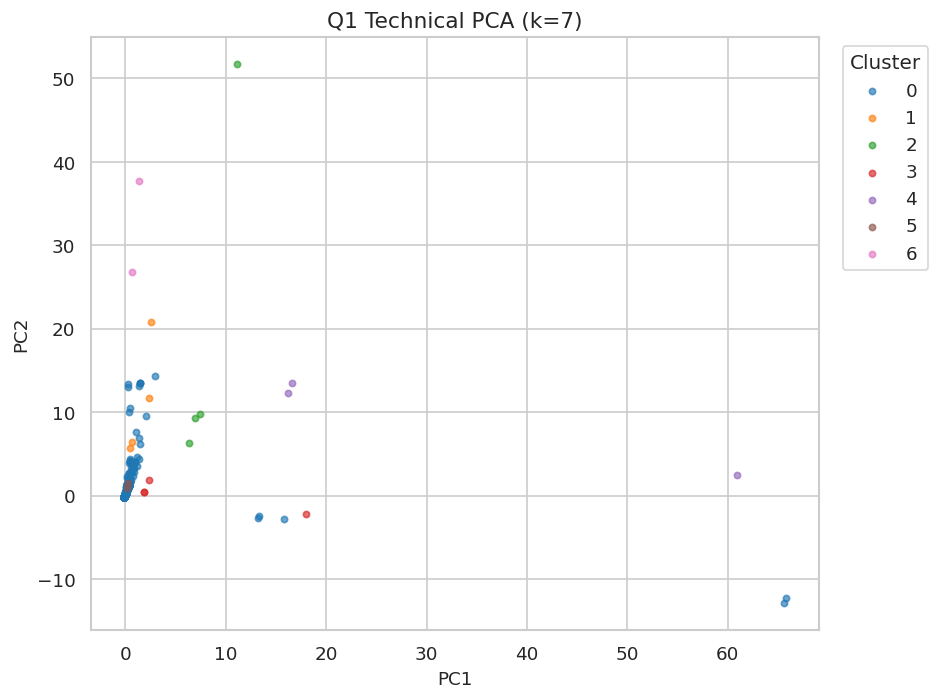

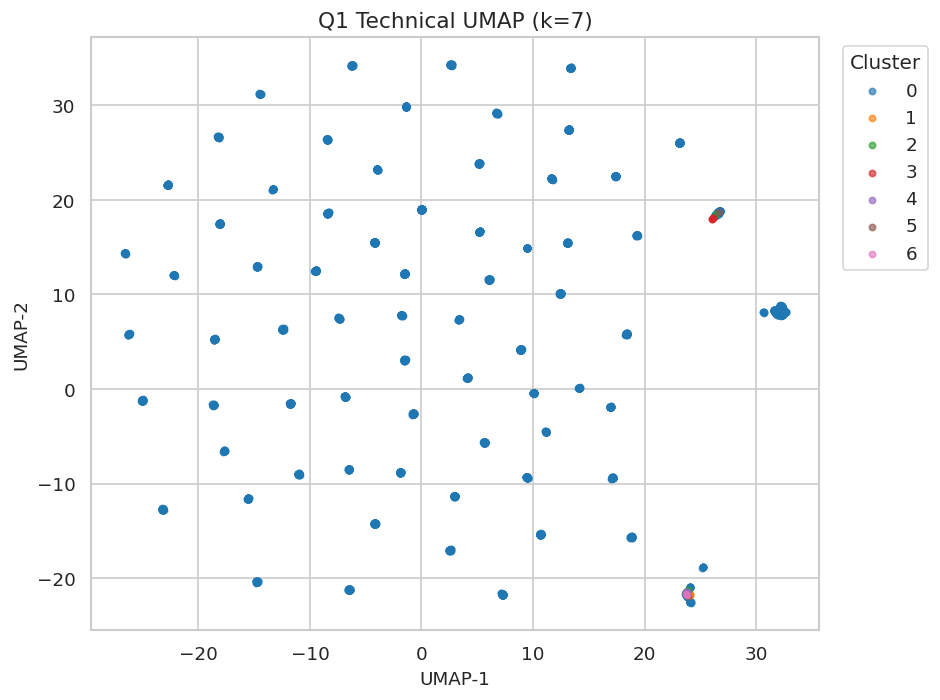

(UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 array([[ 26.593359  ,  18.66417   ],
        [ 24.00743   , -21.68011   ],
        [ 23.999773  , -21.560862  ],
        ...,
        [  2.5046556 , -17.003365  ],
        [ 14.087898  ,   0.07675403],
        [-18.578661  ,   5.275225  ]], dtype=float32))

In [ ]:
# 6.1 Q1 Technical clustering (extensions)
tech_num = [c for c in df_tech.columns if c not in ["appeared","last_activity"]]
X_tech = df_tech[tech_num].copy()
X_tech_prep = pipe.fit_transform(X_tech)

scores_tech = silhouette_sweep_kmeans(X_tech_prep, k_list)
display(scores_tech)
plot_elbow_sil(scores_tech, title_prefix="Q1 Technical")

best_k_tech = int(scores_tech.sort_values("silhouette", ascending=False).iloc[0]["k"])
labels_tech = KMeans(n_clusters=best_k_tech, random_state=RANDOM_STATE, n_init="auto").fit_predict(X_tech_prep)

pca_scatter(X_tech_prep, labels_tech, title=f"Q1 Technical PCA (k={best_k_tech})")
umap_scatter(X_tech_prep, labels_tech, title=f"Q1 Technical UMAP (k={best_k_tech})")


,k,silhouette,inertia
0,2,0.375051,34667.733161
1,3,0.367729,28781.380245
2,4,0.472327,16561.969264
3,5,0.427235,13007.426725
4,6,0.410982,11791.544267
5,7,0.393726,10973.511037
6,8,0.412812,10133.997310
7,9,0.398300,8928.530917
8,10,0.390739,8067.240178


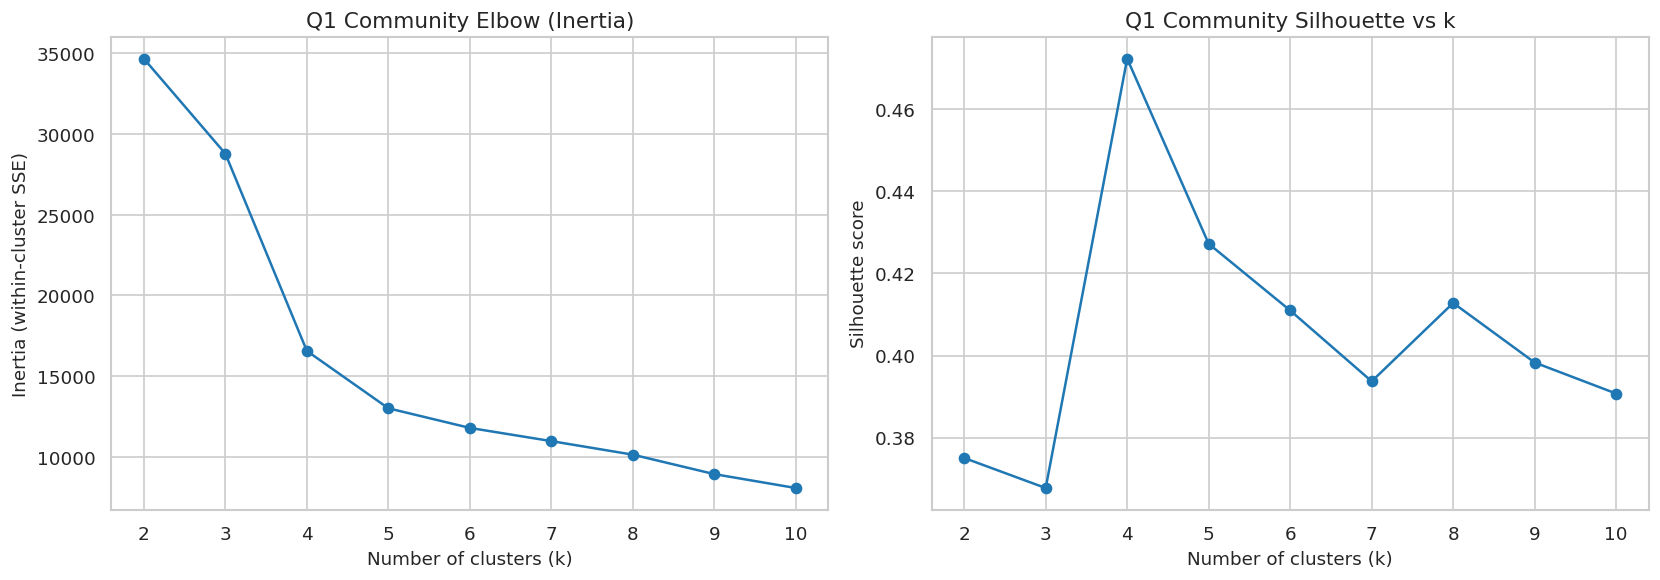

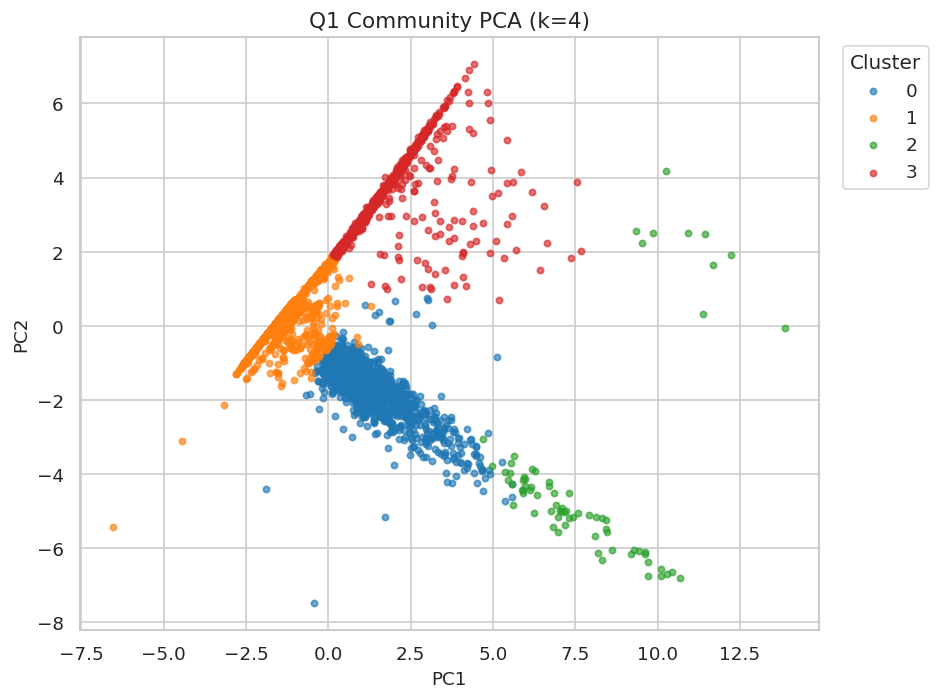

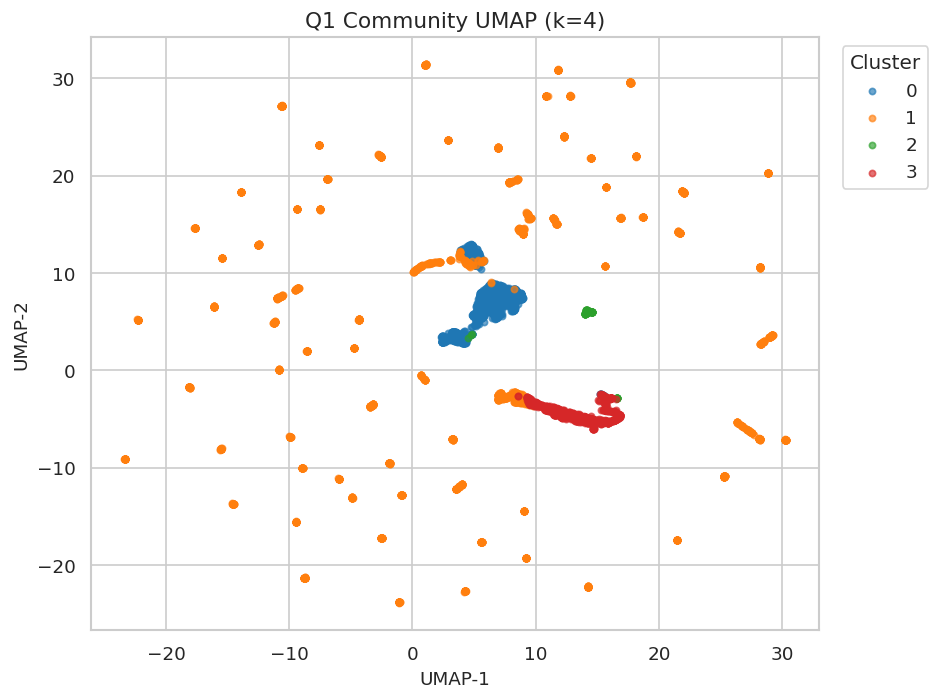

(UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 array([[ 14.604401 ,   6.019957 ],
        [ 14.579653 ,   6.016259 ],
        [ 14.580515 ,   6.0058875],
        ...,
        [ 27.525742 ,  -6.448698 ],
        [-11.149752 ,   5.0130973],
        [ -9.469884 , -15.541862 ]], dtype=float32))

In [ ]:
# 6.2 Q1 Community clustering
X_comm = df_comm.copy()
X_comm_prep = pipe.fit_transform(X_comm)

scores_comm = silhouette_sweep_kmeans(X_comm_prep, k_list)
display(scores_comm)
plot_elbow_sil(scores_comm, title_prefix="Q1 Community")

best_k_comm = int(scores_comm.sort_values("silhouette", ascending=False).iloc[0]["k"])
labels_comm = KMeans(n_clusters=best_k_comm, random_state=RANDOM_STATE, n_init="auto").fit_predict(X_comm_prep)

pca_scatter(X_comm_prep, labels_comm, title=f"Q1 Community PCA (k={best_k_comm})")
umap_scatter(X_comm_prep, labels_comm, title=f"Q1 Community UMAP (k={best_k_comm})")


## 7) Reproduce M2 Q2 (Drishti): Hype vs Utility archetypes

,k,silhouette,inertia
0,2,0.504222,11375.323926
1,3,0.539635,7068.149891
2,4,0.683791,3064.367707
3,5,0.665533,2589.656699
4,6,0.671881,1880.761977
5,7,0.681903,1708.677696
6,8,0.673730,1392.370620
7,9,0.672875,1317.189262
8,10,0.667696,1078.825620


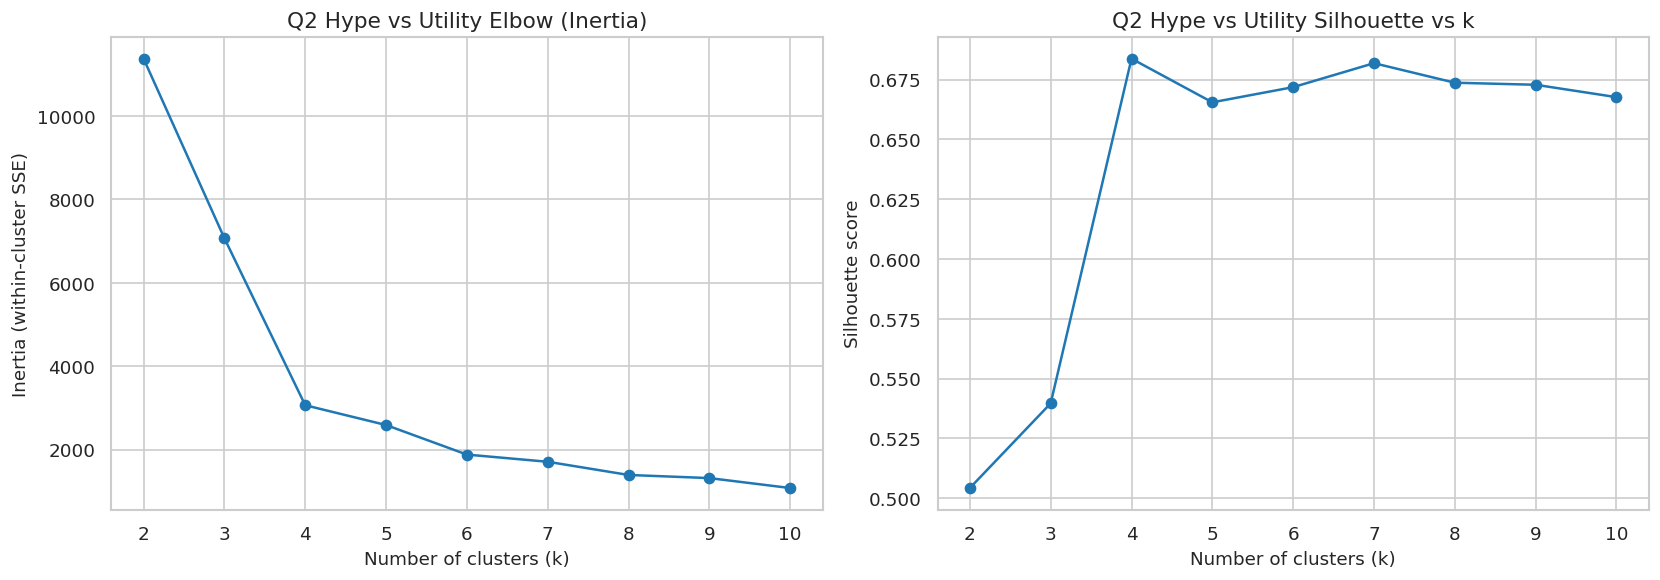

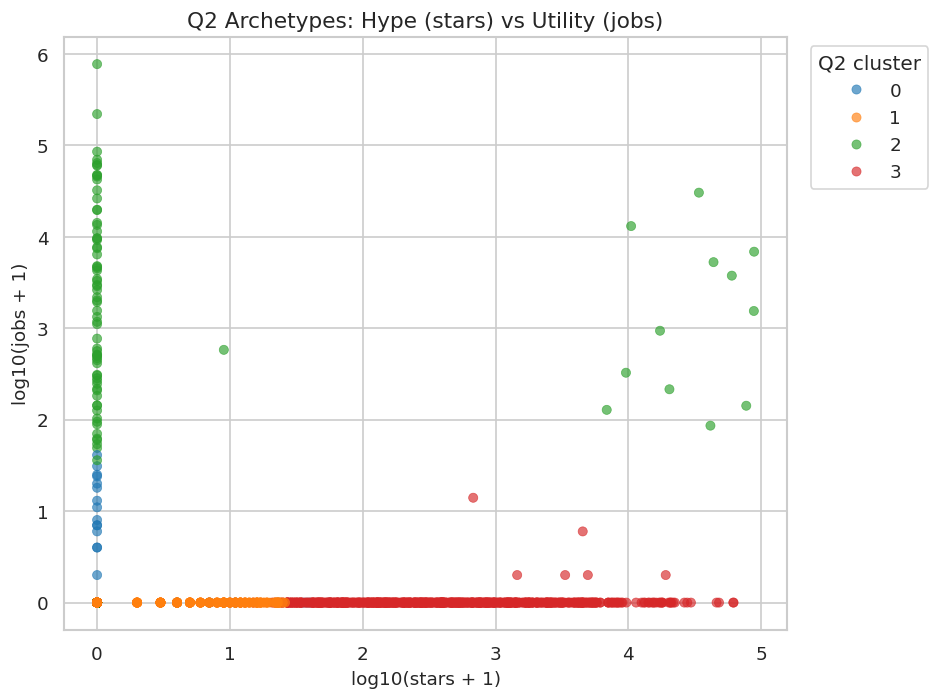

,log10_github_repo_stars,log10_wikipedia_daily_page_views,log10_number_of_users,log10_number_of_jobs
q2_cluster,,,,
0,0.011,1.562,2.387,0.013
1,0.067,0.019,0.323,0.000
2,0.667,2.908,4.757,3.266
3,2.646,0.143,2.808,0.005


In [ ]:
q2_features = ["log10_github_repo_stars","log10_wikipedia_daily_page_views","log10_number_of_users","log10_number_of_jobs"]
q2_features = [c for c in q2_features if c in df_hype.columns]
assert len(q2_features) >= 3, f"Not enough Q2 features found. Available: {df_hype.columns.tolist()}"

X_q2 = df_hype[q2_features].copy()
X_q2_prep = pipe.fit_transform(X_q2)

scores_q2 = silhouette_sweep_kmeans(X_q2_prep, k_list)
display(scores_q2)
plot_elbow_sil(scores_q2, title_prefix="Q2 Hype vs Utility")

k_q2 = 4  # preserve M2 baseline for archetypes
df_hype["q2_cluster"] = KMeans(n_clusters=k_q2, random_state=RANDOM_STATE, n_init="auto").fit_predict(X_q2_prep)

if {"log10_github_repo_stars","log10_number_of_jobs"}.issubset(df_hype.columns):
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df_hype,
        x="log10_github_repo_stars",
        y="log10_number_of_jobs",
        hue="q2_cluster",
        palette=PALETTE,
        s=30,
        alpha=0.65,
        edgecolor=None
    )
    plt.xlabel("log10(stars + 1)")
    plt.ylabel("log10(jobs + 1)")
    plt.title("Q2 Archetypes: Hype (stars) vs Utility (jobs)")
    plt.legend(title="Q2 cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

profile_q2 = df_hype.groupby("q2_cluster")[q2_features].mean().round(3).sort_index()
display(profile_q2)


## 8) Reproduce M2 Q3 (Arshdeep): Ghost languages

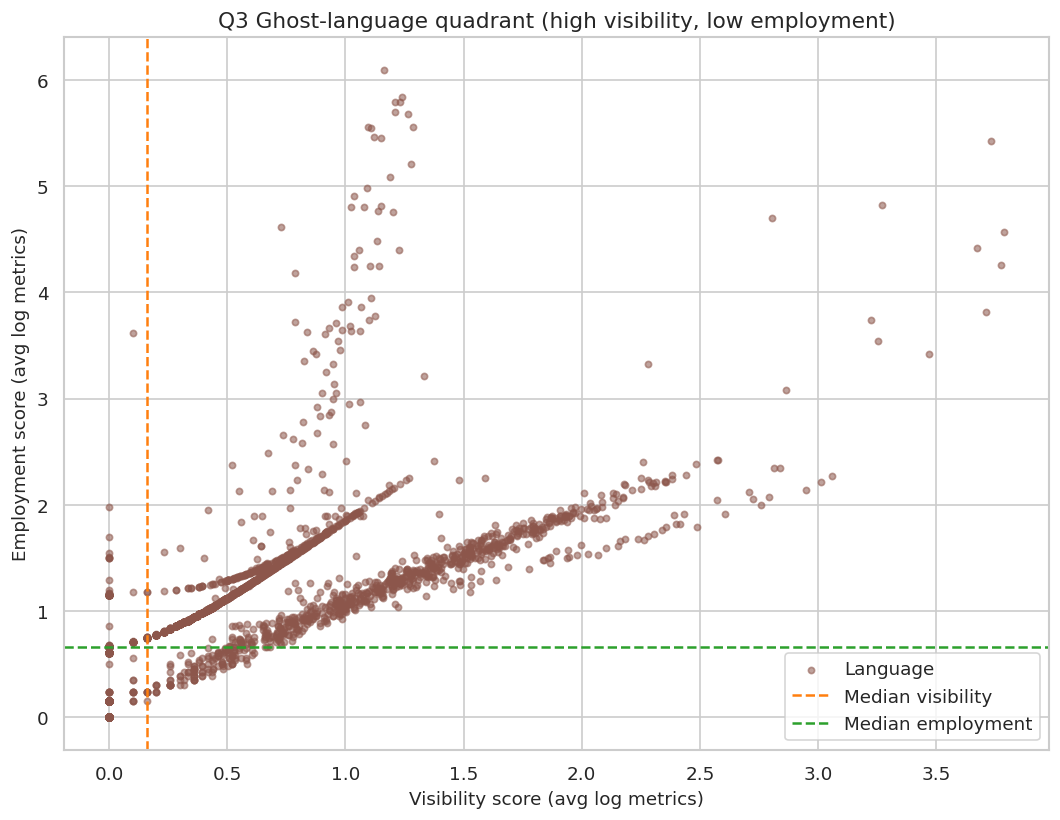

Ghost quadrant count: 128


,title,visibility_score,employment_score
1859,IPL,0.615033,0.602060
2324,polymath,0.604304,0.588046
2419,duro,0.604304,0.627636
2651,Broccoli,0.582729,0.500000
2650,TextFrame,0.580121,0.539591
1779,texti,0.580121,0.556972
1195,Language Server Index Format,0.577465,0.650515
2526,ForthScript,0.569190,0.627636
2422,penguor,0.560414,0.556972
1986,h,0.551071,0.650515


In [ ]:
vis_cols = [c for c in ["log10_github_repo_stars","log10_wikipedia_daily_page_views","log10_github_repo_subscribers"] if c in df_hype.columns]
emp_cols = [c for c in ["log10_number_of_jobs","log10_number_of_users"] if c in df_hype.columns]

assert len(vis_cols) >= 2, f"Need at least 2 visibility cols. Found: {vis_cols}"
assert len(emp_cols) >= 1, f"Need at least 1 employment col. Found: {emp_cols}"

df_hype["visibility_score"] = df_hype[vis_cols].mean(axis=1)
df_hype["employment_score"] = df_hype[emp_cols].mean(axis=1)

x = df_hype["visibility_score"]
y = df_hype["employment_score"]
x_med = x.median()
y_med = y.median()

plt.figure(figsize=(9,7))
plt.scatter(x, y, s=14, alpha=0.55, color=PALETTE[5], label="Language")
plt.axvline(x_med, linestyle="--", color=PALETTE[1], label="Median visibility")
plt.axhline(y_med, linestyle="--", color=PALETTE[2], label="Median employment")
plt.xlabel("Visibility score (avg log metrics)")
plt.ylabel("Employment score (avg log metrics)")
plt.title("Q3 Ghost-language quadrant (high visibility, low employment)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

df_hype["ghost_quadrant"] = np.where((x >= x_med) & (y < y_med), 1, 0)
print("Ghost quadrant count:", int(df_hype["ghost_quadrant"].sum()))

if "title" in df_hype.columns:
    display(df_hype.loc[df_hype["ghost_quadrant"]==1, ["title","visibility_score","employment_score"]]
            .sort_values("visibility_score", ascending=False).head(15))


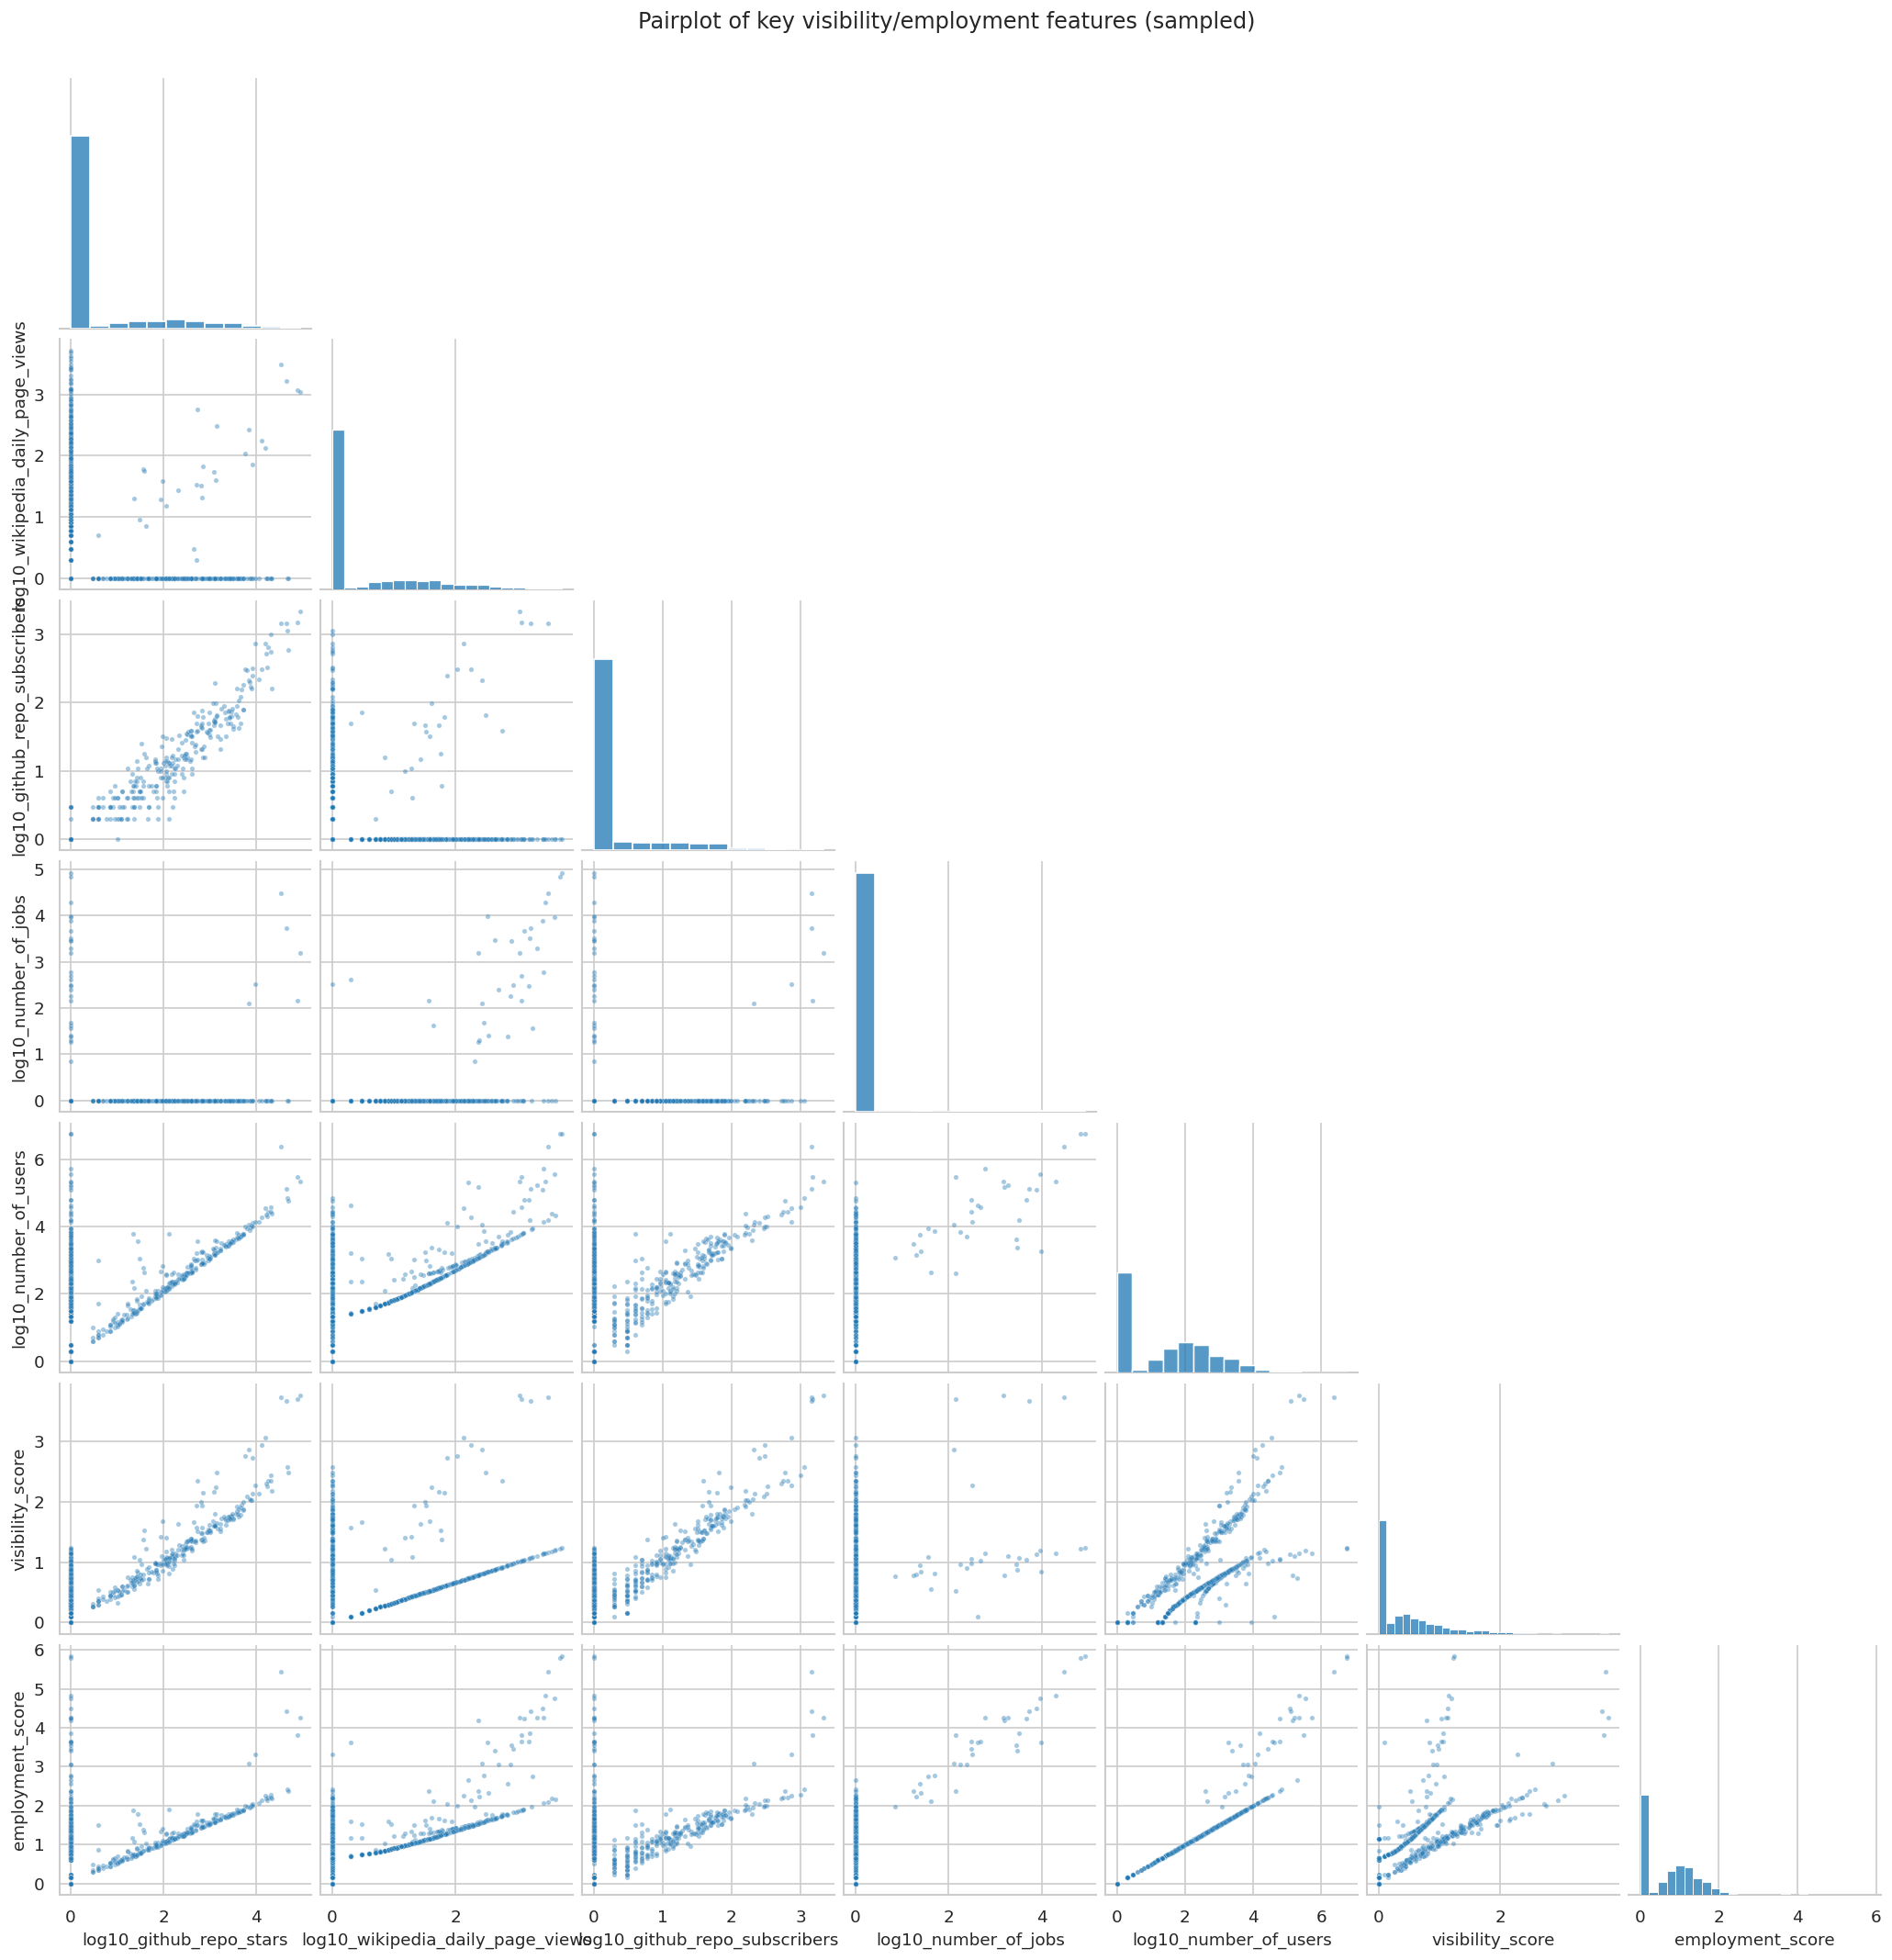

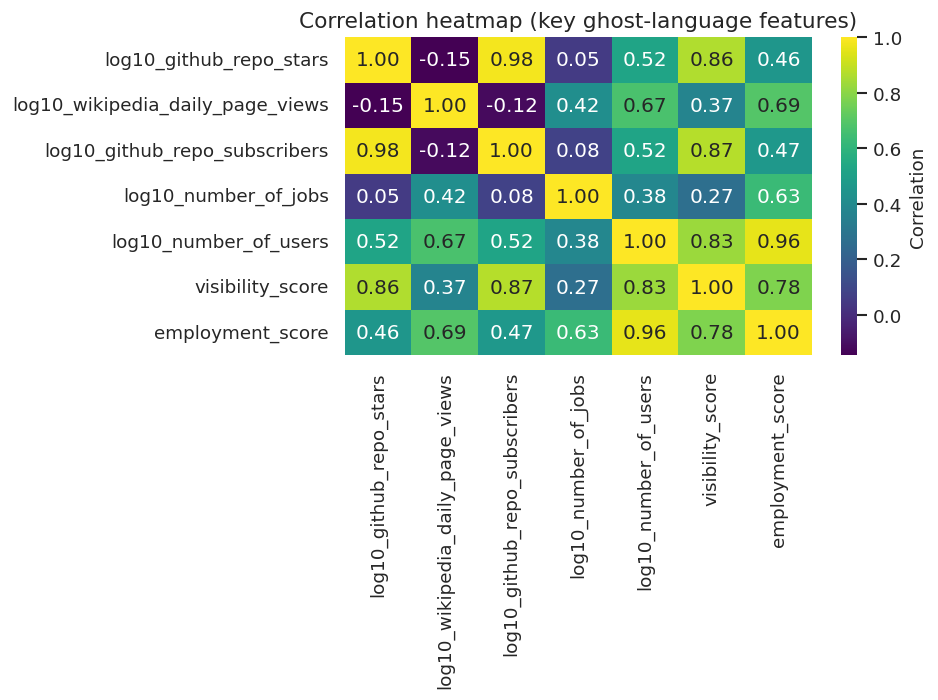

In [ ]:
# Q3 additional visuals (from M2 Q3): pairplot + correlation heatmap
pair_cols = []
for c in ["log10_github_repo_stars","log10_wikipedia_daily_page_views","log10_github_repo_subscribers",
          "log10_number_of_jobs","log10_number_of_users","visibility_score","employment_score"]:
    if c in df_hype.columns:
        pair_cols.append(c)

pair_df = df_hype[pair_cols].dropna()

# downsample for speed if needed
if len(pair_df) > 1200:
    pair_df = pair_df.sample(1200, random_state=RANDOM_STATE)

if len(pair_cols) >= 4 and len(pair_df) > 50:
    sns.pairplot(pair_df, corner=True, plot_kws={"s": 10, "alpha": 0.4})
    plt.suptitle("Pairplot of key visibility/employment features (sampled)", y=1.02)
    plt.show()

    plt.figure(figsize=(8,6))
    sns.heatmap(
        pair_df.corr(numeric_only=True),
        cmap=HEATMAP_CMAP,
        annot=True,
        fmt=".2f",
        cbar_kws={"label":"Correlation"}
    )
    plt.title("Correlation heatmap (key ghost-language features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough columns/rows for pairplot; skipping.")


## 9) Reproduce M2 Q4 (Ahrar): Longevity / survival clustering

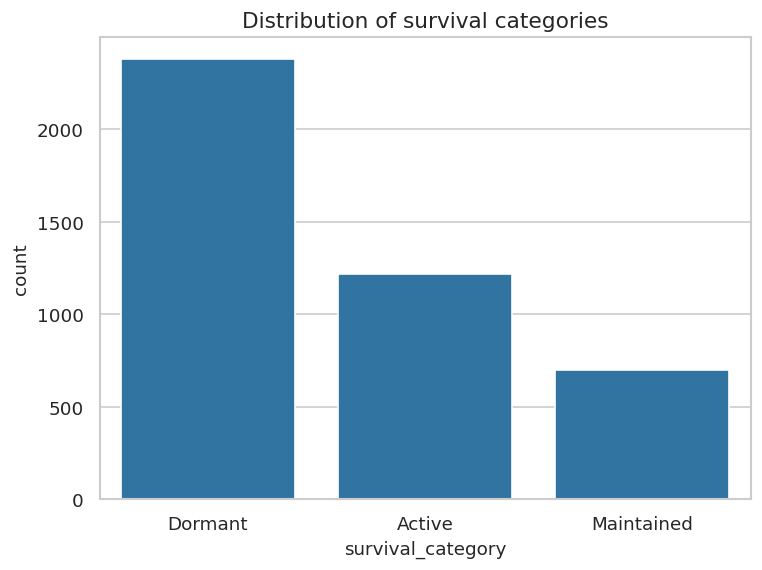

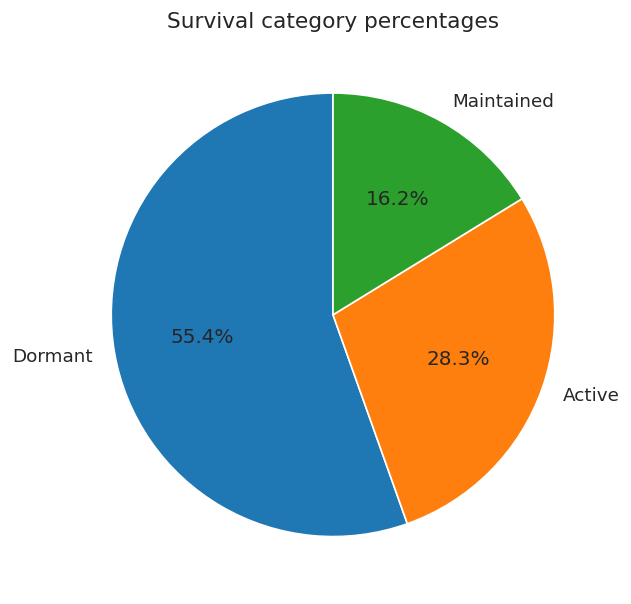

,k,silhouette,inertia
0,2,0.391073,239617.074748
1,3,0.390577,235294.972252
2,4,0.391662,230772.865042
3,5,0.387753,226088.455050
4,6,0.186721,219275.055038
5,7,0.187167,214489.639833
6,8,0.197067,207708.192650
7,9,0.185197,202750.487920
8,10,0.187135,198449.156737


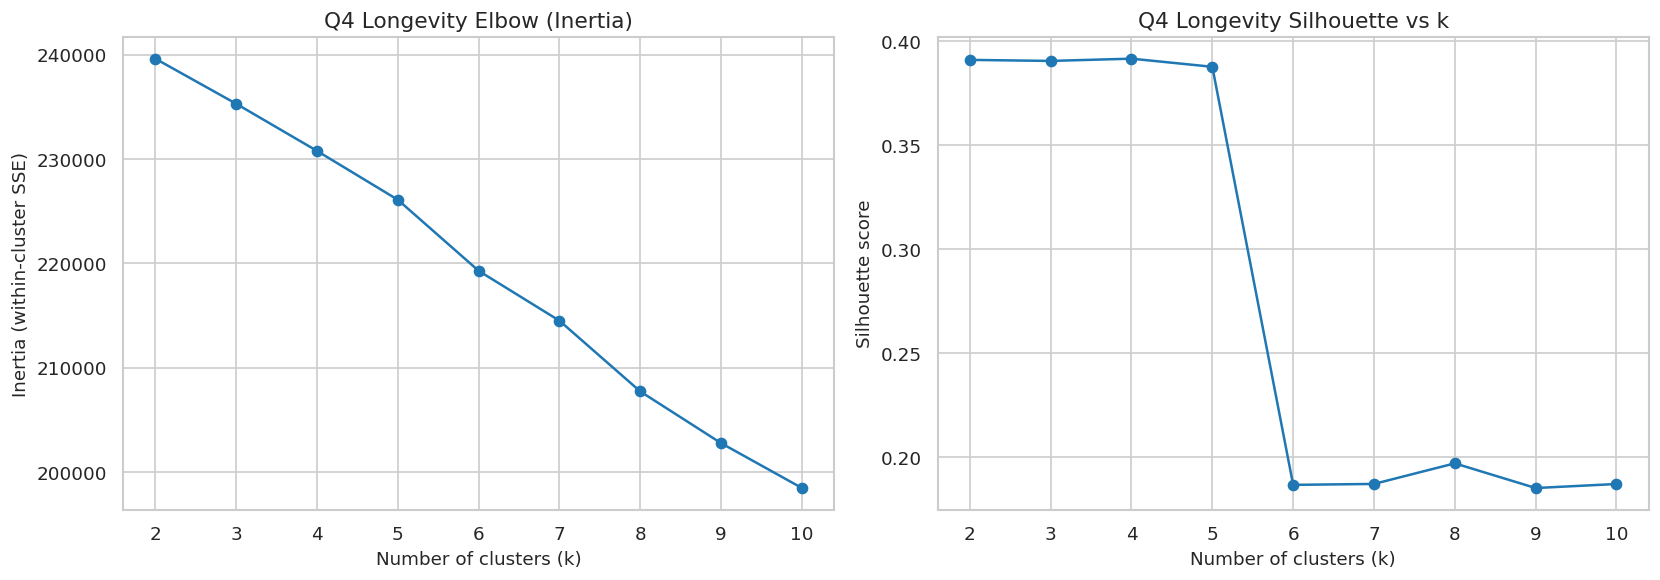

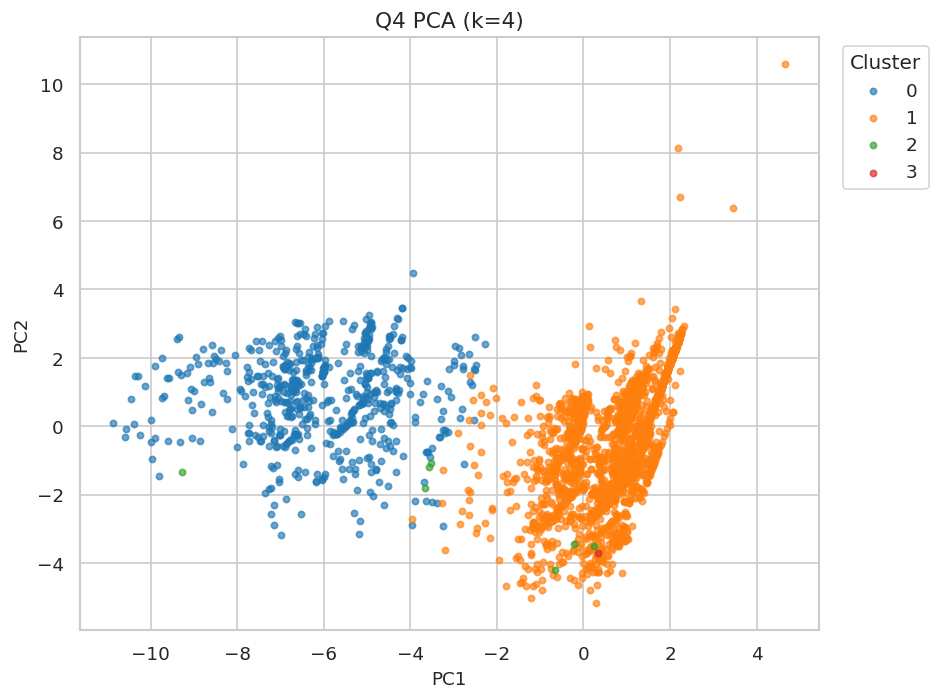

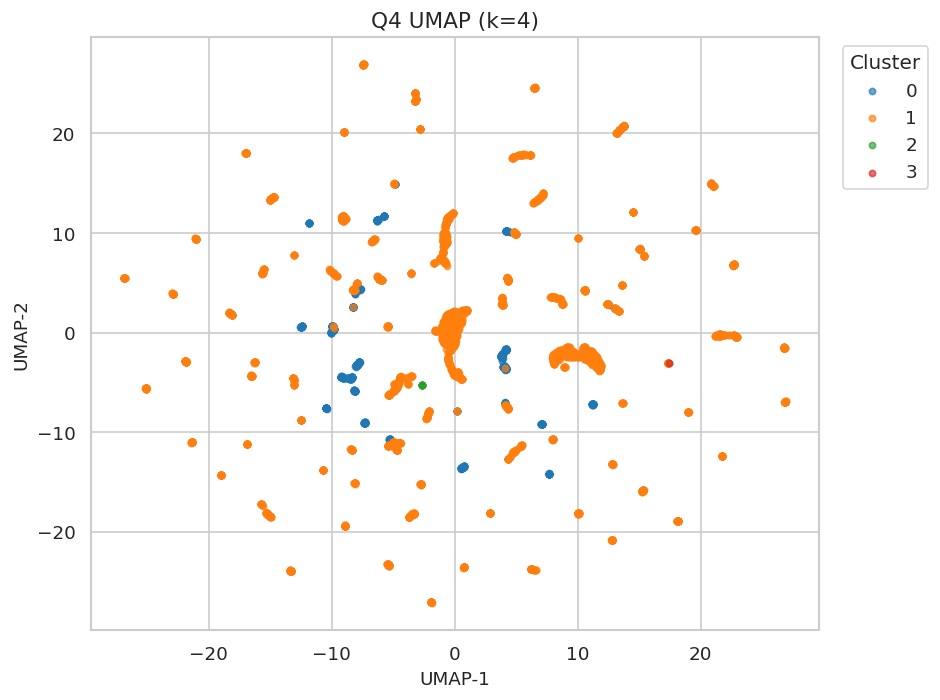

survival_category,Active,Maintained,Dormant
q4_cluster,,,
0,0.556,0.243,0.201
1,0.238,0.149,0.613
2,0.857,0.143,0.000
3,0.000,1.000,0.000


In [ ]:
if "survival_category" in df_clean.columns:
    counts = df_clean["survival_category"].value_counts()
    plt.figure(figsize=(7,5))
    sns.barplot(x=counts.index.astype(str), y=counts.values, color=PALETTE[0])
    plt.title("Distribution of survival categories")
    plt.xlabel("survival_category")
    plt.ylabel("count")
    plt.show()

    plt.figure(figsize=(6,6))
    plt.pie((counts / counts.sum()).values, labels=counts.index.astype(str), autopct="%1.1f%%", startangle=90)
    plt.title("Survival category percentages")
    plt.show()

selected_features = [
    "type","file_type","features_has_comments","features_has_semantic_indentation","features_has_line_comments",
    "has_domain","has_github","has_wikipedia",
    "ecosystem_score","age","years_since_last_activity",
    "log1p_number_of_users","log1p_number_of_jobs","log1p_book_count","log1p_central_package_repository_count"
]
selected_features = [c for c in selected_features if c in df_long.columns]
df_q4 = df_long[selected_features].copy()

categorical_cols = [c for c in ["type","file_type","features_has_comments","features_has_semantic_indentation","features_has_line_comments"] if c in df_q4.columns]
df_q4_enc = pd.get_dummies(df_q4, columns=categorical_cols, dummy_na=True)

X_q4 = df_q4_enc.fillna(0)
X_q4_prep = pipe.fit_transform(X_q4)

scores_q4 = silhouette_sweep_kmeans(X_q4_prep, k_list)
display(scores_q4)
plot_elbow_sil(scores_q4, title_prefix="Q4 Longevity")

best_k_q4 = int(scores_q4.sort_values("silhouette", ascending=False).iloc[0]["k"])
labels_q4 = KMeans(n_clusters=best_k_q4, random_state=RANDOM_STATE, n_init="auto").fit_predict(X_q4_prep)

pca_scatter(X_q4_prep, labels_q4, title=f"Q4 PCA (k={best_k_q4})")
umap_scatter(X_q4_prep, labels_q4, title=f"Q4 UMAP (k={best_k_q4})")

df_tmp = df_clean.copy()
df_tmp["q4_cluster"] = labels_q4
if "survival_category" in df_tmp.columns:
    mix = pd.crosstab(df_tmp["q4_cluster"], df_tmp["survival_category"], normalize="index").round(3)
    display(mix)


## 10) M3 Integrated Clustering (Synergy result)

Integrated columns: ['log1p_github_repo_stars', 'log1p_wikipedia_daily_page_views', 'log1p_number_of_users', 'log1p_number_of_jobs', 'log1p_github_repo_subscribers', 'log1p_github_repo_forks', 'age', 'years_since_last_activity', 'has_domain', 'has_github', 'has_wikipedia', 'num_extensions_listed']


,k,silhouette,inertia
0,2,0.461056,34425.775034
1,3,0.478503,29032.966266
2,4,0.436967,21109.046012
3,5,0.428483,17676.615047
4,6,0.413462,15470.885059
5,7,0.407328,14683.152161
6,8,0.457598,12992.917932
7,9,0.458992,12462.797761
8,10,0.419954,10665.877543


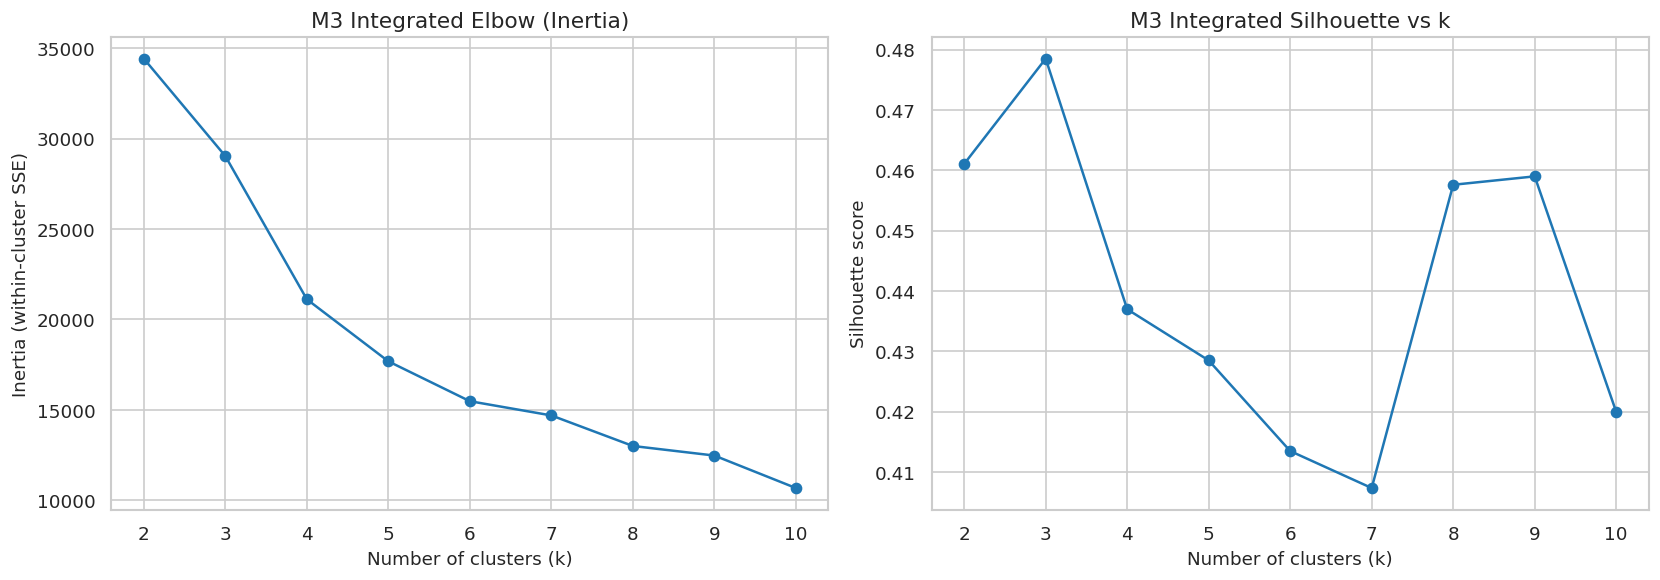

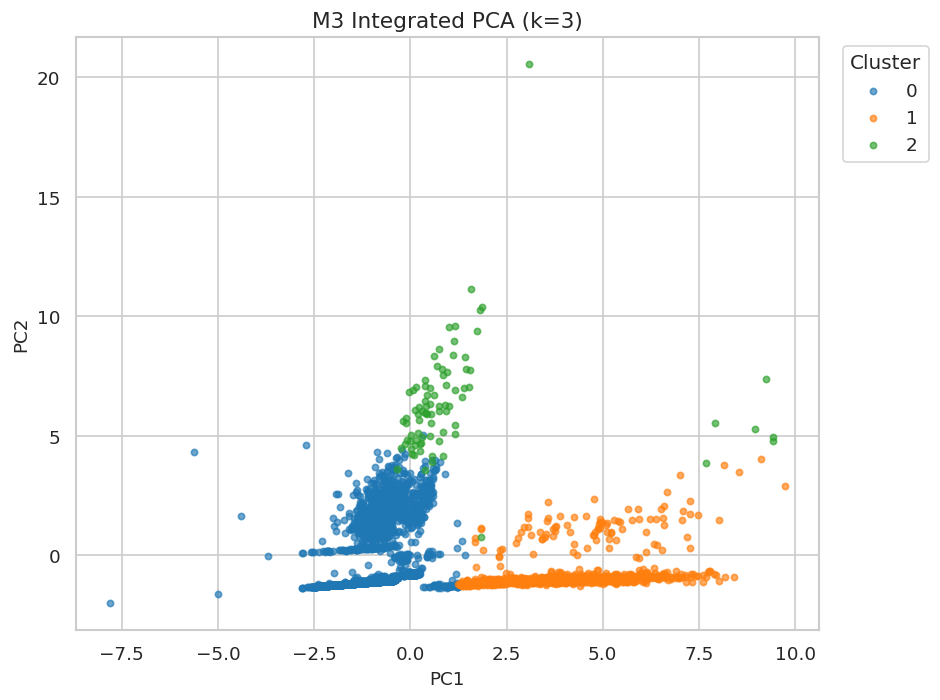

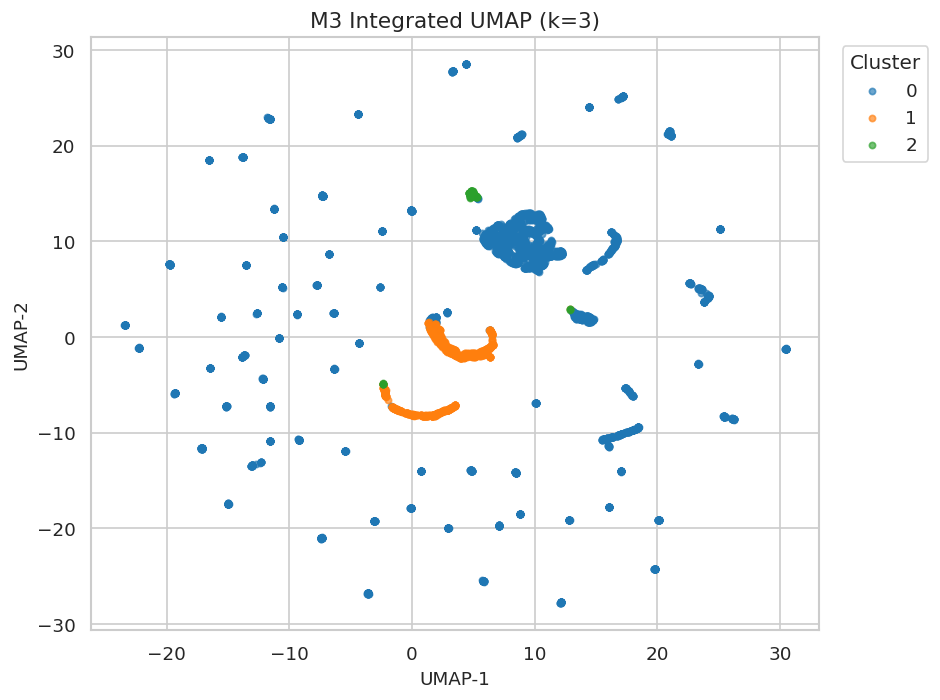

,log1p_github_repo_stars,log1p_wikipedia_daily_page_views,log1p_number_of_users,log1p_number_of_jobs,log1p_github_repo_subscribers,log1p_github_repo_forks,age,years_since_last_activity,has_domain,has_github,has_wikipedia,num_extensions_listed
m3_cluster,,,,,,,,,,,,
0,0.012,1.267,2.289,0.005,0.012,0.002,31.614,24.354,0.107,0.018,0.411,0.157
1,5.438,0.331,5.861,0.050,2.846,3.128,8.916,1.571,0.388,1.000,0.111,0.234
2,0.771,6.671,10.584,7.147,0.517,0.633,31.405,1.476,0.345,0.083,0.988,6.167


q2_cluster,0.0,1.0,2.0,3.0
m3_cluster,,,,
0,0.344,0.656,0.000,0.000
1,0.013,0.168,0.007,0.811
2,0.083,0.012,0.905,0.000


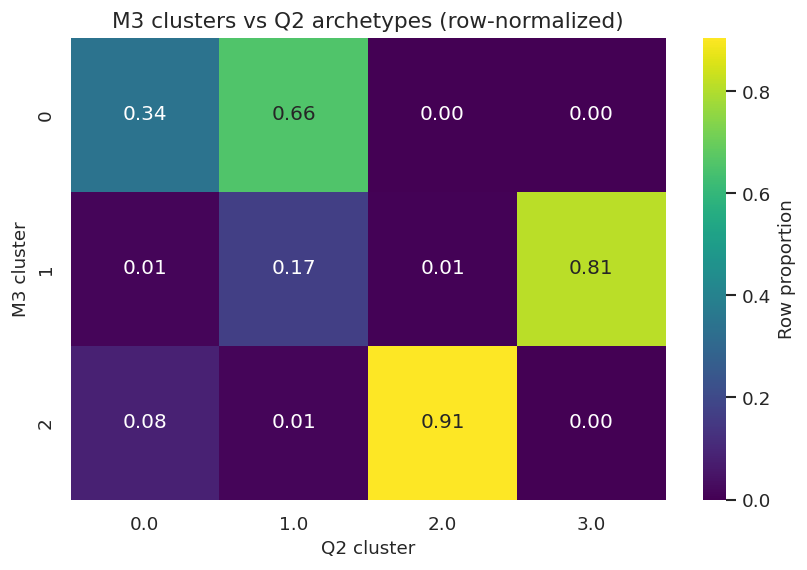

survival_category,Active,Maintained,Dormant
m3_cluster,,,
0,0.108,0.188,0.704
1,0.934,0.064,0.002
2,0.881,0.119,0.000


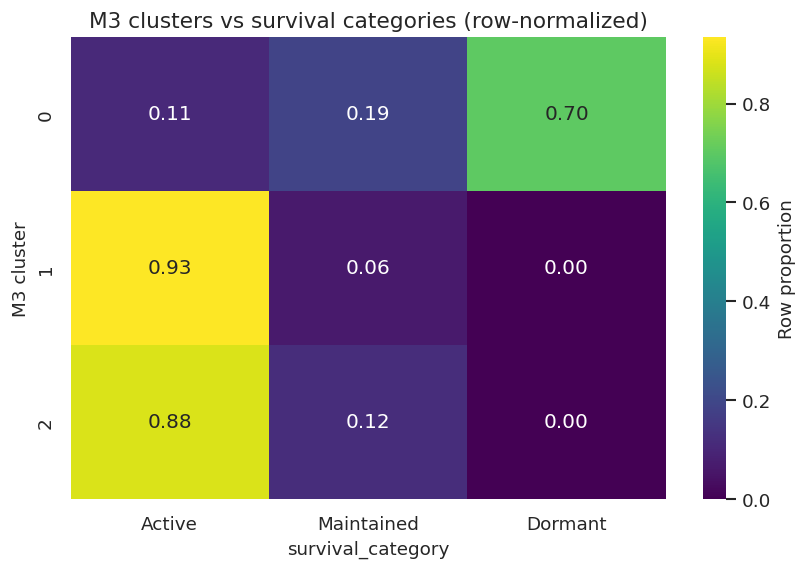


=== M3 cluster 0 examples ===


,title,github_repo_stars,number_of_jobs,wikipedia_daily_page_views
345,NATO phonetic alphabet,NaN,0,13394.0
575,QR code,NaN,0,6415.0
268,Morse code,NaN,0,5843.0
92,TLS,NaN,0,4915.0
84,DOI,NaN,0,4196.0
612,UTC,NaN,0,3949.0
61,Regular Expressions,NaN,0,3569.0
148,URL,NaN,0,3566.0
98,TCP,NaN,0,3336.0
296,DNS,NaN,0,3154.0



=== M3 cluster 1 examples ===


,title,github_repo_stars,number_of_jobs,wikipedia_daily_page_views
37,Node.js,88526.0,6864,NaN
23,Rust,77242.0,141,1159.0
547,Sqlalchemy,62000.0,0,NaN
541,Svelte,61681.0,0,NaN
439,mermaid,48174.0,0,NaN
544,PROMETHEUS,46169.0,0,NaN
35,Julia,41515.0,85,640.0
137,V,29603.0,0,NaN
582,Simple Binary Encoding,27780.0,0,NaN
206,PostCSS,26406.0,0,NaN



=== M3 cluster 2 examples ===


,title,github_repo_stars,number_of_jobs,wikipedia_daily_page_views
38,HTTP,NaN,771996,6702.0
4,SQL,NaN,219617,3084.0
30,TypeScript,88139.0,1542,1098.0
0,Java,NaN,85206,5242.0
6,HTML,NaN,69531,4897.0
1,JavaScript,NaN,63993,4264.0
8,PHP,33991.0,30349,3151.0
2,C,NaN,59919,6268.0
5,C++,NaN,61098,4307.0
20,Swift,60145.0,3754,1501.0


In [ ]:
integrated_cols = []

integrated_cols += [c for c in [
    "log1p_github_repo_stars","log1p_wikipedia_daily_page_views",
    "log1p_number_of_users","log1p_number_of_jobs",
    "log1p_github_repo_subscribers","log1p_github_repo_forks"
] if c in df_clean.columns]

integrated_cols += [c for c in ["age","years_since_last_activity","ecosystem_score"] if c in df_clean.columns]
integrated_cols += [c for c in ["has_domain","has_github","has_wikipedia"] if c in df_clean.columns]
integrated_cols += [c for c in ["num_extensions_listed"] if c in df_clean.columns]

integrated_cols = list(dict.fromkeys(integrated_cols))
print("Integrated columns:", integrated_cols)

X_m3 = df_clean[integrated_cols].copy()
X_m3_prep = pipe.fit_transform(X_m3)

scores_m3 = silhouette_sweep_kmeans(X_m3_prep, k_list)
display(scores_m3)
plot_elbow_sil(scores_m3, title_prefix="M3 Integrated")

best_k_m3 = int(scores_m3.sort_values("silhouette", ascending=False).iloc[0]["k"])
df_clean["m3_cluster"] = KMeans(n_clusters=best_k_m3, random_state=RANDOM_STATE, n_init="auto").fit_predict(X_m3_prep)

pca_scatter(X_m3_prep, df_clean["m3_cluster"], title=f"M3 Integrated PCA (k={best_k_m3})")
umap_scatter(X_m3_prep, df_clean["m3_cluster"], title=f"M3 Integrated UMAP (k={best_k_m3})")

profile_m3 = df_clean.groupby("m3_cluster")[integrated_cols].mean().round(3).sort_index()
display(profile_m3)

# Compare M3 vs Q2 archetypes
df_clean.loc[df_hype.index, "q2_cluster"] = df_hype.get("q2_cluster", np.nan)
if "q2_cluster" in df_clean.columns:
    ctab = pd.crosstab(df_clean["m3_cluster"], df_clean["q2_cluster"], normalize="index").round(3)
    display(ctab)
    plt.figure(figsize=(8,5))
    sns.heatmap(ctab, annot=True, fmt=".2f", cmap=HEATMAP_CMAP, cbar_kws={"label":"Row proportion"})
    plt.title("M3 clusters vs Q2 archetypes (row-normalized)")
    plt.xlabel("Q2 cluster")
    plt.ylabel("M3 cluster")
    plt.show()

# Compare M3 vs survival categories
if "survival_category" in df_clean.columns:
    ctab2 = pd.crosstab(df_clean["m3_cluster"], df_clean["survival_category"], normalize="index").round(3)
    display(ctab2)
    plt.figure(figsize=(8,5))
    sns.heatmap(ctab2, annot=True, fmt=".2f", cmap=HEATMAP_CMAP, cbar_kws={"label":"Row proportion"})
    plt.title("M3 clusters vs survival categories (row-normalized)")
    plt.xlabel("survival_category")
    plt.ylabel("M3 cluster")
    plt.show()

# Examples per cluster
if "title" in df_clean.columns:
    for cl in sorted(df_clean["m3_cluster"].unique()):
        ex = df_clean[df_clean["m3_cluster"]==cl].copy()
        score_cols = [c for c in ["github_repo_stars","number_of_jobs","wikipedia_daily_page_views"] if c in ex.columns]
        if score_cols:
            ex["_score"] = ex[score_cols].fillna(0).sum(axis=1)
            ex = ex.sort_values("_score", ascending=False)
        print(f"\n=== M3 cluster {cl} examples ===")
        display(ex[["title"] + score_cols].head(10))


## 11) M3 Write-up Blocks (copy/paste into your M3 PDF)

### 11.1 Integrated Problem Framing & Updated Questions (8%)
Use (and edit) this “status table” in your PDF to explicitly show what changed from M2:

| Question / Theme (from M1/M2) | M3 Status (unchanged / refined / dropped) | What changed & why (tied to M2 findings) | How integration helped (or didn’t) |
|---|---|---|---|
| Q1: Technical vs community clustering | **Refined** | Technical features are weaker due to limited extension coverage; we keep technical signals as a lightweight feature (num extensions + top dummies) and emphasize community signals. | Shows whether technical signals add incremental separation after unifying preprocessing. |
| Q2: “Hype vs Utility” archetypes | **Unchanged (core framing)** | k=4 remains the baseline archetype choice so we can compare directly to M2. | Integration tests whether longevity + ecosystem changes archetype boundaries. |
| Q3: “Ghost languages” (high attention, low demand) | **Integrated as a diagnostic lens** | Instead of a separate clustering, ghost-ness is used to interpret clusters/archetypes and identify mismatches. | Clarifies which integrated clusters are “ghost-heavy.” |
| Q4: Longevity / survival / ecosystem | **Integrated as explanation + validation** | Longevity features now contextualize hype/utility outcomes (e.g., older & stable vs newly hyped). | Explains *why* clusters differ, not just *that* they differ. |

---

### 11.2 Recap of Individual M2 Contributions (5%)
(Concise bullets — emphasize strengths + limitations.)

- **Vishesh (M2 Q1):** Technical vs community clustering; dimensionality reduction (PCA/UMAP); highlighted limitations of technical features (extensions coverage).  
- **Drishti (M2 Q2):** “Hype vs Utility” archetypes using community adoption metrics; baseline k=4; elbow/silhouette justification + archetype scatterplots.  
- **Arshdeep (M2 Q3):** Ghost-language framing (visibility vs employment scores); quadrant interpretation + correlation/pairplot support.  
- **Ahrar (M2 Q4):** Longevity / survival categorization; ecosystem presence flags; clustering + interpretation of stability vs decline.

---

### 11.3 Integration Strategy & Synergy Effort (20%)
Use this as your “integration log” (explicit reuse/modify/discard evidence). Replace “Owner” with your team’s final attribution.

| Element | Source (M2) | Reused | Modified | Discarded | Why / impact (include failures too) | Owner |
|---|---|---:|---:|---:|---|---|
| Unified missingness + skew EDA | Q2/Q3/Q4 | ✅ | ✅ |  | Reduces repeated EDA and makes M2→M3 comparisons consistent. | Team |
| Numeric casting + log transforms | Q1/Q2/Q3 | ✅ | ✅ |  | Standardized `log1p` & `log10(x+1)` to keep scales comparable. | Team |
| Technical extensions parsing | Q1 | ✅ | ✅ |  | Kept compact tech signal (`num_extensions_listed` + top extensions); acknowledges missingness. | Vishesh |
| Archetype baseline | Q2 | ✅ |  |  | k=4 kept fixed for direct comparison. | Drishti |
| Ghost scoring | Q3 | ✅ | ✅ |  | Integrated as lens; used to interpret M3 clusters. | Arshdeep |
| Survival / longevity features | Q4 | ✅ | ✅ |  | Added age/years since activity + ecosystem flags as explanatory layer. | Ahrar |

---

### 11.4 Integrated Analysis & Results (25%)
Fill these bullets using the printed outputs from Section 10:

- **Integrated feature set used:** *(paste from the notebook printout in Section 10: `Integrated columns: [...]`)*  
- **Best k (by silhouette):** *(paste from Section 10 where `best_k_m3` is computed)*  
- **What changed vs M2:**  
  - Compare **M3 vs Q2** via the row-normalized heatmap (alignment / splitting / merging).  
  - Compare **M3 vs survival_category** heatmap (do clusters map to longevity tiers?).  
- **Cluster profiles:** Use the `profile_m3` table to name clusters (e.g., “High demand + high longevity”, “High attention + low demand (ghost-heavy)”, etc.).  
- **Representative examples:** Use the “examples per cluster” prints to provide concrete languages for each cluster.

> Tip for “Excellent”: name each cluster and write **1–2 sentences** explaining it, grounded in the profile table + example languages.

---

### 11.5 Insights Gained Through Integration (20%)
Write 5–8 sentences (not just restating results). Use prompts like:

- What did we **expect** to happen when adding longevity/ecosystem to hype/utility — and what **actually** happened?
- Which M2 analyses were **redundant** after integration (and why)?
- What assumptions were **challenged** (e.g., “high attention implies high jobs”)?  
- Did integration improve clarity, or did it reveal incompatibilities? Both can earn full credit if documented.

---

### 11.6 Limitations, Open Questions, Next Steps (7%)
Concrete + connected to findings:

- **Limitations:** extension coverage; missingness in demand/attention metrics; correlations may reflect confounding (age, ecosystem size).  
- **Open questions:** what predicts transitions between archetypes over time? do “ghost” languages eventually become utility languages?  
- **Next steps:** stability tests (bootstrapping); add external demand signals (StackOverflow, package downloads); survival modeling beyond categorical bins; refine technical feature extraction.

---

### 11.7 Documentation, Attribution & Compliance (8%)
Add these to your PDF (and keep consistent with GitHub):

- **GitHub repo link:** *(paste here)*  
- **Contribution table:** list technical + idea-level contributions per member.  
- **Generative AI appendix (required if used):**  
  - How AI helped (brainstorming / drafting / code debugging)  
  - What you edited / validated manually  
  - Link(s) to chat logs (if requested by rubric)



In [ ]:
# Optional: quick “paste-ready” bullets (edit to match your actual results)
integration_notes = [
    "Unified preprocessing across all M2 analyses: standardized column names, numeric casting, negative-value handling, and consistent log transforms for skewed community metrics.",
    "Adopted the strongest EDA visuals: missingness table (Q2/Q3), top-missing bar plot (Q4), and log-scale distributions/scatterplots (Q2/Q3).",
    "Preserved Q1’s technical idea by parsing GitHub extensions into num_extensions_listed + top extension dummy features; documented coverage limitations explicitly.",
    "Preserved Q2’s archetype framing with a fixed k=4 baseline to maintain direct comparability between M2 and M3.",
    "Integrated Q3’s ghost-language concept as a diagnostic lens (visibility vs employment) to interpret clusters rather than running it as an isolated analysis.",
    "Integrated Q4’s longevity/ecosystem features to explain why hype/utility clusters differ (age, years since last activity, ecosystem_score, and presence flags)."
]
for b in integration_notes:
    print("•", b)


• Unified preprocessing across all M2 analyses: standardized column names, numeric casting, negative-value handling, and consistent log transforms for skewed community metrics.
• Adopted the strongest EDA visuals: missingness table (Q2/Q3), top-missing bar plot (Q4), and log-scale distributions/scatterplots (Q2/Q3).
• Preserved Q1’s technical idea by parsing GitHub extensions into num_extensions_listed + top extension dummy features; documented coverage limitations explicitly.
• Preserved Q2’s archetype framing with a fixed k=4 baseline to maintain direct comparability between M2 and M3.
• Integrated Q3’s ghost-language concept as a diagnostic lens (visibility vs employment) to interpret clusters rather than running it as an isolated analysis.
• Integrated Q4’s longevity/ecosystem features to explain why hype/utility clusters differ (age, years since last activity, ecosystem_score, and presence flags).
